In [5]:
import pandas as pd
import numpy as np
from scipy.stats import mode, entropy, ttest_ind
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectPercentile
from datetime import datetime, timedelta
import time

import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline 
sns.set(color_codes=True)

import os
os.chdir("/Users/meif/Desktop/SI 699")

pd.set_option('display.max_columns', None)

## 0. Helper Function

In [6]:
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), [df[col] for col in cols])

In [7]:
def time_delta(strCur, ndays):
    return (datetime.strptime(strCur, "%Y-%m-%d") - timedelta(days=ndays)).strftime("%Y-%m-%d")

In [8]:
def is_weekend(string):
    if type(string) != type(""):
        return string
    a = datetime.strptime(string, "%Y-%m-%d %H:%M:%S").isoweekday()
    if a < 6:
        return 0
    return 1

In [9]:
def covers_weekend(x):
    if type(x[0]) != type(""):
        return x[0]
    start_time = datetime.strptime(x[0], "%Y-%m-%d")
    end_time = datetime.strptime(x[1], "%Y-%m-%d %H:%M:%S")
    if (end_time - start_time).days > 5:
        return 1
    for i in range(6):
        if start_time + timedelta(days=i) <= end_time:
            if start_time.isoweekday() + i > 5:
                return 1
    return 0

In [10]:
def covers_nday(x):

    if type(x[0]) != type(""):
        return [x[0]] * 7

    start_time = datetime.strptime(x[0], "%Y-%m-%d")
    end_time = datetime.strptime(x[1], "%Y-%m-%d %H:%M:%S")
    if (end_time - start_time).days > 7:
        return [1] * 7
    
    res = [0] * 7 # mon ~ sun
    for i in range(7):
        cur = start_time + timedelta(days=i)
        if cur <= end_time:
            res[cur.weekday()] = 1
            
    return res

In [2]:
def getVar(start_time, fill_na):
    
    # construct features
    
    if start_time > "2016-04-07 00:00:00":
        
        couponBefore = dataset2[(dataset2["coupon_id"] != 0) & (dataset2["start_time"] < start_time)]
        orderBefore = dataset2[(dataset2["order_no"].notna()) & (dataset2["send_time"] < start_time)]
        couponCur = dataset2[(dataset2["coupon_id"] != 0) & (dataset2["start_time"] == start_time)]
        orderCur = dataset2[(dataset2["order_no"].notna()) & (dataset2["send_time"] == start_time)]
        
        user_id = couponCur["user_id"].to_frame("user_id")

        
        ## Distance, location
        distance_median_date = orderBefore.groupby("user_id")["distance"].median().to_frame("distance_median_date").reset_index()
        distance_std_date = orderBefore.groupby("user_id")["distance"].std().to_frame("distance_std_date").reset_index()
        user_longitude_median_date = orderBefore.groupby("user_id")["user_longitude"].median().to_frame("user_longitude_median_date").reset_index()
        user_longitude_std_date = orderBefore.groupby("user_id")["user_longitude"].std().to_frame("user_longitude_std_date").reset_index()
        user_latitude_median_date = orderBefore.groupby("user_id")["user_latitude"].median().to_frame("user_latitude_median_date").reset_index()
        user_latitude_std_date = orderBefore.groupby("user_id")["user_latitude"].std().to_frame("user_latitude_std_date").reset_index()
        
        user_id = user_id.join(distance_median_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(distance_std_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(user_longitude_median_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(user_longitude_std_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(user_latitude_median_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(user_latitude_std_date.set_index('user_id'), on="user_id", how="left")
        
        print("Finished Distance and Location")
        
        
        ## Worth Money
        worth_money_median_date = orderBefore.groupby("user_id")["worth_money"].median().to_frame("worth_money_median_date").reset_index()
        worth_money_std_date = orderBefore.groupby("user_id")["worth_money"].std().to_frame("worth_money_std_date").reset_index()

        user_id = user_id.join(worth_money_median_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(worth_money_std_date.set_index('user_id'), on="user_id", how="left")
        
        print("Finished Worth Money")
        
        
        ## RelWizKit
        kitchen_entropy_date = orderBefore.groupby("user_id")["kitchen_id"].value_counts().to_frame("kitchen_count_date").reset_index()[["user_id", "kitchen_count_date"]].groupby("user_id").apply(lambda x:entropy(x)[-1]).to_frame("kitchen_entropy_date").reset_index()
        
        user_id = user_id.join(kitchen_entropy_date.set_index('user_id'), on="user_id", how="left")
        
        print("Finished RelWizKit entropy")

        
        ## AppVerLast
        AppVerLast_date = orderBefore.groupby("user_id")["app_version"].last().to_frame("AppVerLast_date").reset_index()
    
        user_id = user_id.join(AppVerLast_date.set_index('user_id'), on="user_id", how="left")

        print("Finished AppVerLast")
           
        
        ## CoupUseLast
        CoupUseLast_date = orderBefore.groupby("user_id")["is_used"].last().to_frame("CoupUseLast_date").reset_index()
    
        user_id = user_id.join(CoupUseLast_date.set_index('user_id'), on="user_id", how="left")

        print("Finished CoupUseLast")
        
        
        ## coupon usage rate
        cur_data = couponBefore.copy()
        cur_data["is_used2"] = 0
        cur_data["is_used2"][cur_data["use_time"] < start_time] = 1
        
        coupon_count_date = cur_data.groupby("user_id").size().to_frame("coupon_count_date").reset_index()
        coupon_count_used_date = cur_data[cur_data["is_used2"] == 1].groupby("user_id").size().to_frame("coupon_count_used_date").reset_index()
        coupon_count_used_weekend_date = cur_data[(cur_data["is_used2"] == 1) & (cur_data["is_weekend"] == 1)].groupby("user_id").size().to_frame("coupon_count_used_weekend_date").reset_index()

        user_id = user_id.join(coupon_count_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(coupon_count_used_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(coupon_count_used_weekend_date.set_index('user_id'), on="user_id", how="left")

        print("Finished coupon usage rate")
        
        
        ## coupon usage rate over orders
        order_count_date = orderBefore.groupby("user_id").size().to_frame("order_count_date").reset_index()
        order_coupon_count_date = orderBefore[orderBefore["coupon_id"] != 0].groupby("user_id").size().to_frame("order_coupon_count_date").reset_index()
        order_count_weekend_date = orderBefore[orderBefore["is_weekend"] == 1].groupby("user_id").size().to_frame("order_count_weekend_date").reset_index()

        user_id = user_id.join(order_count_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(order_coupon_count_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(order_count_weekend_date.set_index('user_id'), on="user_id", how="left")

        print("Finished coupon usage rate over orders")
        
        
        
        # count
        WeeklyCouponUsedCount_date = cur_data[cur_data["start_time"] > time_delta(start_time, 7)][cur_data["is_used2"] == 1].groupby("user_id").size().to_frame("WeeklyCouponUsedCount_date").reset_index()
        BiWeeklyCouponUsedCount_date = cur_data[cur_data["start_time"] > time_delta(start_time, 14)][cur_data["is_used2"] == 1].groupby("user_id").size().to_frame("BiWeeklyCouponUsedCount_date").reset_index()

        user_id = user_id.join(WeeklyCouponUsedCount_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(BiWeeklyCouponUsedCount_date.set_index('user_id'), on="user_id", how="left")

        
        WeeklyOrderCount_date = orderBefore[orderBefore["send_time"] > time_delta(start_time, 7)].groupby("user_id").size().to_frame("WeeklyOrderCount_date").reset_index()
        BiWeeklyOrderCount_date = orderBefore[orderBefore["send_time"] > time_delta(start_time, 14)].groupby("user_id").size().to_frame("BiWeeklyOrderCount_date").reset_index()

        user_id = user_id.join(WeeklyOrderCount_date.set_index('user_id'), on="user_id", how="left")
        user_id = user_id.join(BiWeeklyOrderCount_date.set_index('user_id'), on="user_id", how="left")
        
        print("Finished coupon count")
        
        ## combine        
        res = user_id.iloc[:,1:]
        res.loc[(res["distance_median_date"].notna()) & (res["distance_std_date"].isna()), "distance_std_date"] = 0
        res.loc[(res["user_longitude_median_date"].notna()) & (res["user_longitude_std_date"].isna()), "user_longitude_std_date"] = 0 
        res.loc[(res["user_latitude_median_date"].notna()) & (res["user_latitude_std_date"].isna()), "user_latitude_std_date"] = 0
        res.loc[(res["worth_money_median_date"].notna()) & (res["worth_money_std_date"].isna()), "worth_money_std_date"] = 0
        
        res.loc[res["coupon_count_date"].isna(), "coupon_count_date"] = 0
        res.loc[res["coupon_count_used_date"].isna(), "coupon_count_used_date"] = 0
        res.loc[res["coupon_count_used_weekend_date"].isna(), "coupon_count_used_weekend_date"] = 0        
        
        res.loc[res["order_count_date"].isna(), "order_count_date"] = 0
        res.loc[res["order_coupon_count_date"].isna(), "order_coupon_count_date"] = 0
        res.loc[res["order_count_weekend_date"].isna(), "order_count_weekend_date"] = 0
        
        res.loc[res["WeeklyCouponUsedCount_date"].isna(), "WeeklyCouponUsedCount_date"] = 0
        res.loc[res["BiWeeklyCouponUsedCount_date"].isna(), "BiWeeklyCouponUsedCount_date"] = 0
        res.loc[res["WeeklyOrderCount_date"].isna(), "WeeklyOrderCount_date"] = 0
        res.loc[res["BiWeeklyOrderCount_date"].isna(), "BiWeeklyOrderCount_date"] = 0
        
        if fill_na:
            res["AppVerLast_date"].fillna(res["AppVerLast_date"].mode()[0], inplace=True)
            res["CoupUseLast_date"].fillna(res["CoupUseLast_date"].mode()[0], inplace=True)
            res.fillna(res.median(), inplace=True)
            
        return res

In [2]:
def getVar2(start_time, fill_na):
    
    # construct features
    
    if start_time > "2016-04-07 00:00:00":
        
        #couponBefore = dataset2[(dataset2["coupon_id"] != 0) & (dataset2["start_time"] < start_time)]
        orderBefore = dataset2[(~dataset2["order_no"].isnull()) & (dataset2["send_time"] < start_time)]
        couponCur = dataset2[(dataset2["coupon_id"] != 0) & (dataset2["start_time"] == start_time)]
        #orderCur = dataset2[(~dataset2["order_no"].isnull()) & (dataset2["send_time"] == start_time)]
        
        user_id = couponCur["user_id"].to_frame("user_id")

        
        ## coupon usage rate
        distance_mean_date = orderBefore.groupby("user_id")["distance"].mean().to_frame("distance_mean_date").reset_index()
        user_id = user_id.join(distance_mean_date.set_index('user_id'), on="user_id", how="left")


        print("Finished order count")
        
        ## combine        
        res = user_id.iloc[:,1:]
        res.fillna(res.median(), inplace=True)

        
        return res        

In [3]:
getVar2("2016-04-09", True)

NameError: global name 'dataset2' is not defined

## Features

**1. User Features**

> Coupon Usage Rate | Coupon Usage Rate over Order | Coupon Usage Rate over Type

> Distance: Mean/Median Distance to the Kitchens | Mean/Median create_send_min

> Version: Smart Phone Update Version

> RelWizKit: Relationship with Kitchen (entropy)

> Sex

> Age

> City

**2. Coupon Features**

> EffectiveDays

> Money

> Max Money

> Worth Money

> reason

**3. Sensitivity to promotional coupons / RFM**

> TotOrders (order_count): total # of orders by the customer

> TotWorthMoney: total amount of money (worth money) spent by the customer

> TotMoney: total amount of money (money) spent by the customer

> TotNumCoup (coupon_count_used): represents the total number of coupons a customer ever redeemed in the past

> RecencyCoup: the number of days that elapsed since a customer redeemed a coupon

> InterOrder: the average number of days between customer order

> InterCoup: the average number of days between customer coupon redemption

> WeekendVsWorkingDay

> CoupUse_last: a dummy indicating whether or not (1/0) a customer made use of a coupon during his/her last visit

> WeeklyOrderCount, BiWeeklyOrderCount, MonthlyOrderCount

> rSIFreqIncr_lor: indicate whether the redemption of coupons relative to the frequency of store visits increased, decreased or remained stable compared to the situation middle the customers’ length of relationship 

> rSIFreqIncr_last: compared to the last purchase incidence



## 1. Data Preprocessing

read: dataset_180208v2.csv

write: dataset_180209v2.csv

In [6]:
start = time.time()
orig_data = pd.read_csv("Dataset/dataset_180208v2.csv").iloc[:,1:]
print("Spent: {} sec".format(time.time() - start))

Spent: 28.646011114120483 sec


In [11]:
orig_data.head()

,user_id,coupon_id,order_no,kitchen_id,city_id_orders,distance,user_longitude,user_latitude,app_version,send_time,is_used,type,money,max_money,worth_money,reason,start_time,use_time,end_time,coupon_effective_days,sex,age,city_id_user
0,1,0,4.619022e+14,35927.0,110100.0,NaN,NaN,NaN,2.7,2016-04-29 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,80.0,NaN
1,1,0,4.624445e+14,22750.0,110100.0,NaN,NaN,NaN,2.7,2016-05-05 19:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,80.0,NaN
2,1,13014911,4.598215e+14,43494.0,110100.0,1948.0,116.492963,39.912651,2.6,2016-04-05 12:00:00,1.0,6.0,5.0,20.0,20.0,NaN,2016-04-05 00:00:00,2016-04-05 09:57:51,2016-04-05 23:59:59,0.958333,1.0,80.0,NaN
3,1,13024321,4.598279e+14,29574.0,110100.0,3459.0,116.492963,39.912651,2.6,2016-04-05 12:45:00,1.0,5.0,2.0,2.0,2.0,NaN,2016-04-05 00:00:00,2016-04-05 11:44:55,2016-04-12 23:59:59,7.958333,1.0,80.0,NaN
4,1,13047268,4.599184e+14,60125.0,110100.0,6011.0,116.492963,39.912651,2.6,2016-04-06 15:30:00,1.0,5.0,3.0,3.0,3.0,NaN,2016-04-06 00:00:00,2016-04-06 12:53:15,2016-04-13 23:59:59,7.958333,1.0,80.0,NaN


In [12]:
# construct user_coupon index
start = time.time()

dataset = orig_data.copy()
dataset["user_coupon"] = str_join(dataset, "_", "user_id", "coupon_id")
dataset["start_time"] = dataset.start_time.str[:10]
dataset["is_used"].fillna(0, inplace=True) # unused = no oder + having order but not used
dataset.sort_values(by=["start_time", "user_id"], inplace=True)
dataset = dataset.reset_index(drop=True)

print("Spent: {} sec".format(time.time() - start))

Spent: 39.777841329574585 sec


In [13]:
# keep the first transaction if coupon duplicated
start = time.time()

unique_coupon_index = dataset[dataset["coupon_id"] != 0]["coupon_id"].drop_duplicates(keep="first").index.tolist()
unique_coupon_index += dataset[dataset["coupon_id"] == 0].index.tolist()
unique_coupon_index.sort()
dataset = dataset.iloc[unique_coupon_index,]
dataset.loc[(dataset["coupon_id"] != 0) & (dataset["coupon_id"].duplicated()),] # check
dataset.reset_index(drop=True, inplace=True)

print("Spent: {} sec".format(time.time() - start))

Spent: 7.7840399742126465 sec


In [14]:
# extract weekend / working days
dataset["is_weekend"] = dataset["send_time"].apply(lambda x:is_weekend(x))

In [15]:
# covers day
start = time.time()

weekdays = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
for weekday in range(len(weekdays)):
    dataset["covers_{}".format(weekdays[weekday])] = 0

a = dataset.loc[:,["start_time", "end_time"]].apply(covers_nday, axis=1)
dataset.iloc[:,-7:] = np.array([np.array(i) for i in a])

print("Spent: {} sec".format(time.time() - start))

Spent: 732.2996687889099 sec


In [16]:
# factorize type
start = time.time()

dataset.loc[dataset["type"].isna(), "type"] = "type_NA"
dataset.loc[dataset["type"] == 1, "type"] = "type1"
dataset.loc[dataset["type"] == 5, "type"] = "type5"
dataset.loc[dataset["type"] == 6, "type"] = "type6"

lb_type = preprocessing.LabelBinarizer()
lb_type.fit(dataset["type"])
_type = pd.DataFrame(lb_type.transform(dataset["type"]), columns=lb_type.classes_)
dataset = pd.concat([dataset, _type], axis=1, join_axes=[dataset.index])

print("Spent: {} sec".format(time.time() - start))

Spent: 51.095191955566406 sec


In [17]:
# factorize reason
start = time.time()

dataset.loc[dataset["reason"] == "Eventsoperation2016526154547", "reason"] = "Eventsoperation"
dataset.loc[dataset["reason"] == "Eventsoperation201651712150", "reason"] = "Eventsoperation"
dataset.loc[dataset["reason"].isna(),"reason"] = "reason_NA"
reasonTypes = dataset['reason'].value_counts()[:18].index.tolist()
dataset.loc[~dataset["reason"].isin(reasonTypes), "reason"] = "Complaints"
reasonTypes += ["Complaints"]

lb_reason = preprocessing.LabelBinarizer()
lb_reason.fit(dataset["reason"])
reason = pd.DataFrame(lb_reason.transform(dataset["reason"]), columns=lb_reason.classes_)
dataset = pd.concat([dataset, reason], axis=1, join_axes=[dataset.index])

print("Spent: {} sec".format(time.time() - start))

Spent: 73.04185605049133 sec


In [19]:
# factorize sex
start = time.time()

dataset.loc[(dataset["sex"].isna()) | (dataset["sex"] == 0), "sex"] = "sex_NA"
dataset.loc[dataset["sex"] == 1, "sex"] = "sex_1"
dataset.loc[dataset["sex"] == 2, "sex"] = "sex_2"

lb_sex = preprocessing.LabelBinarizer()
lb_sex.fit(dataset["sex"])
sex = pd.DataFrame(lb_sex.transform(dataset["sex"]), columns=lb_sex.classes_)
dataset = pd.concat([dataset, sex], axis=1, join_axes=[dataset.index])

print("Spent: {} sec".format(time.time() - start))

Spent: 66.36058521270752 sec


In [23]:
# factorize age
start = time.time()

dataset.loc[dataset["age"].isna(), "age"] = "age_NA"
dataset.loc[dataset["age"] == 0, "age"] = "age_0"
dataset.loc[dataset["age"] == 60, "age"] = "age_60"
dataset.loc[dataset["age"] == 70, "age"] = "age_70"
dataset.loc[dataset["age"] == 80, "age"] = "age_80"
dataset.loc[dataset["age"] == 90, "age"] = "age_90"

lb_age = preprocessing.LabelBinarizer()
lb_age.fit(dataset["age"])
age = pd.DataFrame(lb_age.transform(dataset["age"]), columns=lb_age.classes_)
dataset = pd.concat([dataset, age], axis=1, join_axes=[dataset.index])

print("Spent: {} sec".format(time.time() - start))

Spent: 69.30247974395752 sec


In [24]:
# factorize city
start = time.time()

dataset.loc[(dataset["city_id_orders"].isna()) & (~dataset["city_id_user"].isna()), "city_id_orders"] = dataset.loc[(dataset["city_id_orders"].isna()) & (~dataset["city_id_user"].isna()), "city_id_user"]
dataset.drop(columns = ["city_id_user"], inplace=True)
dataset.rename(columns={"city_id_orders": "city_id"}, inplace=True)

dataset.loc[dataset["city_id"].isna(), "city_id"] = "city_NA"
dataset.loc[dataset["city_id"].isin([110000, 110100]), "city_id"] = "city1"
dataset.loc[dataset["city_id"].isin([310000, 310100]), "city_id"] = "city2"
dataset.loc[dataset["city_id"] == 330100, "city_id"] = "city3"
dataset.loc[dataset["city_id"] == 440300, "city_id"] = "city4"
dataset.loc[dataset["city_id"] == 440100, "city_id"] = "city5"

lb_city = preprocessing.LabelBinarizer()
lb_city.fit(dataset["city_id"])
city = pd.DataFrame(lb_city.transform(dataset["city_id"]), columns=lb_city.classes_)
dataset = pd.concat([dataset, city], axis=1, join_axes=[dataset.index])

print("Spent: {} sec".format(time.time() - start))

Spent: 73.52572011947632 sec


In [140]:
# cate_features = lb_type.classes_.tolist() + lb_reason.classes_.tolist() + lb_sex.classes_.tolist() + lb_age.classes_.tolist() + lb_city.classes_.tolist()

In [25]:
print(len(dataset))
dataset.head()

6001449


,user_id,coupon_id,order_no,kitchen_id,city_id,distance,user_longitude,user_latitude,app_version,send_time,is_used,type,money,max_money,worth_money,reason,start_time,use_time,end_time,coupon_effective_days,sex,age,user_coupon,is_weekend,covers_mon,covers_tue,covers_wed,covers_thu,covers_fri,covers_sat,covers_sun,type1,type5,type6,type_NA,Complaints,Eventsoperation,NewUserCouponPackageByBD,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,reason_NA,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,sex_1,sex_2,sex_NA,age_0,age_60,age_70,age_80,age_90,age_NA,city1,city2,city3,city4,city5,city_NA
0,16,12964067,NaN,NaN,city_NA,NaN,NaN,NaN,NaN,NaN,0.0,type5,8.0,8.0,0.0,reason_NA,2016-04-01,NaN,2016-04-08 23:59:59,7.958333,sex_NA,age_NA,16_12964067,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,25,12962852,NaN,NaN,city_NA,NaN,NaN,NaN,NaN,NaN,0.0,type1,7.0,7.0,0.0,shareuser,2016-04-01,NaN,2016-04-07 23:59:59,6.958333,sex_1,age_80,25_12962852,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,25,12962853,4.599347e+14,5075.0,city1,1893.0,116.480763,39.910551,2.6,2016-04-06 18:30:00,1.0,type1,8.0,8.0,8.0,shareuser,2016-04-01,2016-04-06 17:25:08,2016-04-07 23:59:59,6.958333,sex_1,age_80,25_12962853,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,25,12962854,NaN,NaN,city_NA,NaN,NaN,NaN,NaN,NaN,0.0,type1,5.0,5.0,0.0,shareuser,2016-04-01,NaN,2016-04-15 23:59:59,14.958333,sex_1,age_80,25_12962854,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,25,12962855,NaN,NaN,city_NA,NaN,NaN,NaN,NaN,NaN,0.0,type1,5.0,5.0,0.0,shareuser,2016-04-01,NaN,2016-04-15 23:59:59,14.958333,sex_1,age_80,25_12962855,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [26]:
dataset.to_csv("dataset_180209v2.csv")

## 1.1 Add Variables

read: dataset_180209v2.csv

write: dataset_180304v2.csv

In [3]:
start = time.time()
dataset = pd.read_csv("dataset_180209v2.csv").iloc[:,1:]
print("Spent: {} sec".format(time.time() - start))

C:\VApps\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Spent: 34.6649999619 sec


In [4]:
# class_type = lb_type.classes_.tolist()
# class_reason = lb_reason.classes_.tolist() 
# class_sex = lb_sex.classes_.tolist() 
# class_age = lb_age.classes_.tolist()
# class_city = lb_city.classes_.tolist()

class_type = ['type1', 'type5', 'type6', 'type_NA']
class_reason = ['Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily',
 'home201603222253', 'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan',
 'preuser', 'reason_NA', 'shareuser', '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀']
class_sex = ['sex_1', 'sex_2', 'sex_NA']
class_age = ['age_0', 'age_60', 'age_70', 'age_80', 'age_90', 'age_NA']
class_city = ['city1', 'city2', 'city3', 'city4', 'city5', 'city_NA']

In [15]:
# dataset_new: dataset to be constructed
main_col = ["user_coupon", "user_id", "coupon_id", "start_time", "is_used", "end_time"]
coupon_col = ["coupon_effective_days", "money", "max_money", "covers_mon", "covers_tue", "covers_wed", "covers_thu", "covers_fri", "covers_sat", "covers_sun", "type"] + class_type + ["reason"] + class_reason
user_col = ["sex"] + class_sex + ["age"] + class_age + ["city_id"] + class_city
order_col = []

dataset_new = dataset[dataset["coupon_id"] != 0][main_col + coupon_col + user_col + order_col]
print(len(dataset_new))
dataset_new.head()

5689657


,user_coupon,user_id,coupon_id,start_time,is_used,end_time,coupon_effective_days,money,max_money,covers_mon,covers_tue,covers_wed,covers_thu,covers_fri,covers_sat,covers_sun,type,type1,type5,type6,type_NA,reason,Complaints,Eventsoperation,NewUserCouponPackageByBD,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,reason_NA,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,sex,sex_1,sex_2,sex_NA,age,age_0,age_60,age_70,age_80,age_90,age_NA,city_id,city1,city2,city3,city4,city5,city_NA
0,16_12964067,16,12964067,2016-04-01,0.0,2016-04-08 23:59:59,7.958333,8.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,type5,0,1,0,0,reason_NA,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,sex_NA,0,0,1,age_NA,0,0,0,0,0,1,city_NA,0,0,0,0,0,1
1,25_12962852,25,12962852,2016-04-01,0.0,2016-04-07 23:59:59,6.958333,7.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,type1,1,0,0,0,shareuser,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,sex_1,1,0,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1
2,25_12962853,25,12962853,2016-04-01,1.0,2016-04-07 23:59:59,6.958333,8.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,type1,1,0,0,0,shareuser,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,sex_1,1,0,0,age_80,0,0,0,1,0,0,city1,1,0,0,0,0,0
3,25_12962854,25,12962854,2016-04-01,0.0,2016-04-15 23:59:59,14.958333,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,type1,1,0,0,0,shareuser,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,sex_1,1,0,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1
4,25_12962855,25,12962855,2016-04-01,0.0,2016-04-15 23:59:59,14.958333,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,type1,1,0,0,0,shareuser,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,sex_1,1,0,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1


In [ ]:
# initiate new features
dataset2 = dataset.copy()
unique_start_date = dataset2["start_time"].unique()[:-1]

dataset2["distance_median_date"] = 0
dataset2["distance_std_date"] = 0
dataset2["user_longitude_median_date"] = 0
dataset2["user_longitude_std_date"] = 0
dataset2["user_latitude_median_date"] = 0
dataset2["user_latitude_std_date"] = 0
dataset2["worth_money_median_date"] = 0
dataset2["worth_money_std_date"] = 0

dataset2["kitchen_entropy_date"] = 0

dataset2["AppVerLast_date"] = 0
dataset2["CoupUseLast_date"] = 0

dataset2["coupon_count_date"] = 0
dataset2["coupon_count_used_date"] = 0
dataset2["coupon_count_used_weekend_date"] = 0

dataset2["order_count_date"] = 0
dataset2["order_coupon_count_date"] = 0
dataset2["order_count_weekend_date"] = 0

dataset2["WeeklyCouponUsedCount_date"] = 0
dataset2["BiWeeklyCouponUsedCount_date"] = 0
dataset2["WeeklyOrderCount_date"] = 0
dataset2["BiWeeklyOrderCount_date"] = 0

In [6]:
# initiate new features
dataset2 = dataset.copy()
unique_start_date = dataset2["start_time"].unique()[:-1]

dataset2["distance_mean_date"] = 0

In [8]:
getVar2("2016-04-08", False).shape

Finished order count


C:\VApps\Anaconda2\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(229909, 1)

In [9]:
dataset2[dataset2["start_time"] == "2016-04-08"].shape

(229909, 70)

In [7]:
## add variable: constructed
for i in unique_start_date:
    print(i)
    if i > "2016-04-07 00:00:00":
        start = time.time()
        
        idx = dataset2[dataset2["start_time"] == i].index
        dataset2.iloc[idx,-1:] = getVar2(i, fill_na = True)

        print("Spent: {} sec".format(time.time() - start))

2016-04-01
2016-04-02
2016-04-03
2016-04-04
2016-04-05
2016-04-06
2016-04-07
2016-04-08
Finished order count


C:\VApps\Anaconda2\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Spent: 6.3860001564 sec
2016-04-09
Finished order count
Spent: 1.8259999752 sec
2016-04-10
Finished order count
Spent: 0.996999979019 sec
2016-04-11
Finished order count
Spent: 1.49699997902 sec
2016-04-12
Finished order count
Spent: 1.11800003052 sec
2016-04-13
Finished order count
Spent: 1.17000007629 sec
2016-04-14
Finished order count
Spent: 1.15499997139 sec
2016-04-15
Finished order count
Spent: 1.12599992752 sec
2016-04-16
Finished order count
Spent: 1.05400013924 sec
2016-04-17
Finished order count
Spent: 1.06399989128 sec
2016-04-18
Finished order count
Spent: 1.20500016212 sec
2016-04-19
Finished order count
Spent: 1.09999990463 sec
2016-04-20
Finished order count
Spent: 1.125 sec
2016-04-21
Finished order count
Spent: 1.14400005341 sec
2016-04-22
Finished order count
Spent: 1.27999997139 sec
2016-04-23
Finished order count
Spent: 1.11000013351 sec
2016-04-24
Finished order count
Spent: 1.16499996185 sec
2016-04-25
Finished order count
Spent: 2.19600009918 sec
2016-04-26
Fini

In [8]:
dataset3 = dataset2[(dataset2["start_time"] > "2016-04-07") & (dataset2["coupon_id"] != 0)]
dataset3 = pd.concat([dataset3[["user_coupon"]], dataset3.iloc[:,-1:]], axis=1, join_axes=[dataset3.index])

In [9]:
dataset3.reset_index(inplace=True, drop=True)
# dataset3 = dataset3.rename(lambda x:x.replace("_date", ""), axis='columns')

In [39]:
dataset3.to_csv("count.csv")

In [16]:
dataset_new = pd.merge(dataset_new[["user_coupon", "is_used", "start_time"]], dataset3, on="user_coupon")
# dataset_new = dataset_new.rename(lambda x:x.replace("_date", ""), axis='columns')
dataset_new

,user_coupon,is_used,start_time,distance_mean_date
0,14_13159484,1.0,2016-04-08,1802.166667
1,59_13161460,0.0,2016-04-08,857.000000
2,59_13162460,0.0,2016-04-08,857.000000
3,60_13161461,0.0,2016-04-08,1377.000000
4,60_13162461,0.0,2016-04-08,1377.000000
5,62_13161462,0.0,2016-04-08,1377.000000
6,62_13162462,0.0,2016-04-08,1377.000000
7,64_13161463,0.0,2016-04-08,1301.000000
8,64_13162463,0.0,2016-04-08,1301.000000
9,66_13161464,0.0,2016-04-08,1751.000000


In [41]:
dataset_new["coupon_usage_rate"] = dataset_new["coupon_count_used"] / dataset_new["coupon_count"]
dataset_new["order_coupon_usage_rate"] = dataset_new["order_coupon_count"] / dataset_new["order_count"]

dataset_new["coupon_used_weekend_perc"] = dataset_new["coupon_count_used_weekend"] / dataset_new["coupon_count_used"]
dataset_new["order_weekend_perc"] = dataset_new["order_count_weekend"] / dataset_new["order_count"]

dataset_new.loc[:,["coupon_usage_rate","order_coupon_usage_rate","coupon_used_weekend_perc","order_weekend_perc"]] = dataset_new[["coupon_usage_rate","order_coupon_usage_rate","coupon_used_weekend_perc","order_weekend_perc"]].fillna(0)

In [43]:
# factorize app version
start = time.time()

dataset_new.loc[dataset_new["AppVerLast"] == 2.1, "AppVerLast"] = "AppVerLast_2.1"
dataset_new.loc[dataset_new["AppVerLast"] == 2.2, "AppVerLast"] = "AppVerLast_2.2"
dataset_new.loc[dataset_new["AppVerLast"] == 2.3, "AppVerLast"] = "AppVerLast_2.3"
dataset_new.loc[dataset_new["AppVerLast"] == 2.4, "AppVerLast"] = "AppVerLast_2.4"
dataset_new.loc[dataset_new["AppVerLast"] == 2.5, "AppVerLast"] = "AppVerLast_2.5"
dataset_new.loc[dataset_new["AppVerLast"] == 2.6, "AppVerLast"] = "AppVerLast_2.6"
dataset_new.loc[dataset_new["AppVerLast"] == 2.7, "AppVerLast"] = "AppVerLast_2.7"
dataset_new.loc[dataset_new["AppVerLast"] == 2.8, "AppVerLast"] = "AppVerLast_2.8"

lb_AppVerLast = preprocessing.LabelBinarizer()
lb_AppVerLast.fit(dataset_new["AppVerLast"])
AppVerLast = pd.DataFrame(lb_AppVerLast.transform(dataset_new["AppVerLast"]), columns=lb_AppVerLast.classes_)
dataset_new = pd.concat([dataset_new, AppVerLast], axis=1, join_axes=[dataset_new.index])

print("Spent: {} sec".format(time.time() - start))

Spent: 185.82209014892578 sec


In [ ]:
dataset_new.columns

In [53]:
dataset_new.to_csv("dataset_180304v2.csv")

In [51]:
dataset_180304 = dataset_new

## 1.2 Combine Dataset

read: dataset_180304v2.csv + Phoebe_trainset_180310.csv + Phoebe_testset_180310.csv

write: dataset_180305v2.csv

In [19]:
dataset_180304 = pd.read_csv("Dataset/dataset_180304v2.csv").iloc[:,1:]
print(len(dataset_180304))
dataset_180304.head()

5484528


,user_coupon,user_id,coupon_id,start_time,is_used,end_time,coupon_effective_days,money,max_money,covers_mon,covers_tue,covers_wed,covers_thu,covers_fri,covers_sat,covers_sun,type,type1,type5,type6,type_NA,reason,Complaints,Eventsoperation,NewUserCouponPackageByBD,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,reason_NA,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,sex,sex_1,sex_2,sex_NA,age,age_0,age_60,age_70,age_80,age_90,age_NA,city_id,city1,city2,city3,city4,city5,city_NA,distance_median,distance_std,user_longitude_median,user_longitude_std,user_latitude_median,user_latitude_std,worth_money_median,worth_money_std,kitchen_entropy,AppVerLast,CoupUseLast,coupon_count,coupon_count_used,coupon_count_used_weekend,order_count,BiWeeklyOrderCount,order_coupon_count,order_count_weekend,coupon_usage_rate,order_coupon_usage_rate,coupon_used_weekend_perc,order_weekend_perc,AppVerLast_2.1,AppVerLast_2.2,AppVerLast_2.3,AppVerLast_2.4,AppVerLast_2.5,AppVerLast_2.6,AppVerLast_2.7,AppVerLast_2.8
0,14_13159484,14,13159484,2016-04-08,1.0,2016-04-08 23:59:59,0.958333,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type5,0,1,0,0,reason_NA,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,sex_NA,0,0,1,age_NA,0,0,0,0,0,1,city3,0,0,1,0,0,0,2156.0,833.795758,120.182450,1.573879,30.263791,3.930686,8.0,0.0,1.242453,AppVerLast_2.6,0.0,5.0,1.0,0.0,6.0,6.0,1.0,1.0,0.2,0.166667,0.0,0.166667,0,0,0,0,0,1,0,0
1,59_13161460,59,13161460,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_2,0,1,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,857.0,0.000000,116.277084,0.000000,39.957024,0.000000,8.0,0.0,0.000000,AppVerLast_2.6,0.0,13.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0
2,59_13162460,59,13162460,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_2,0,1,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,857.0,0.000000,116.277084,0.000000,39.957024,0.000000,8.0,0.0,0.000000,AppVerLast_2.6,0.0,13.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0
3,60_13161461,60,13161461,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_90,0,0,0,0,1,0,city_NA,0,0,0,0,0,1,1365.0,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.0,0.000000,AppVerLast_2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0
4,60_13162461,60,13162461,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_90,0,0,0,0,1,0,city_NA,0,0,0,0,0,1,1365.0,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.0,0.000000,AppVerLast_2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0


In [5]:
# dataset_phoebe1 = pd.read_csv("Phoebe_trainset_180310.csv").iloc[:,1:]
# dataset_phoebe2 = pd.read_csv("Phoebe_testset_180310.csv").iloc[:,1:]
# dataset_phoebe = dataset_phoebe1.append(dataset_phoebe2)
# dataset_phoebe.reset_index(drop=True, inplace=True)
# print(len(dataset_phoebe))
# dataset_phoebe.head()

5484528


,user_coupon,user_id,coupon_id,start_time,is_used,sex_1.0,sex_2.0,age_60.0,age_70.0,age_80.0,age_90.0,age_0.0,city1,city2,city3,city4,city5,distance_mean,distance_median,distance_std,kitchen_entropy,type1,type6,money,coupon_effective_days,covers_tuesday,covers_weekend,Complaints,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,coupon_count_used,coupon_usage_rate,order_count,MonthlyOrderCount,BiWeeklyOrderCount,order_coupon_usage_rate,coupon_used_weekend_perc,order_weekend_perc,coupon_type1_usage_rate,coupon_type6_usage_rate,CoupUseLast,InterCoup,InterOrder,Recency
0,14_13159484,14,13159484,2016-04-08 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1802.166667,2156.0,833.795758,1.242453,0,0,5.0,0.958333,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.2,6.0,6.0,6.0,0.166667,0.0,0.166667,0.333333,0.0,0.0,1500.0,25.4,24.0
1,59_13161460,59,13161460,2016-04-08 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,857.000000,857.0,0.000000,0.000000,1,0,6.0,0.958333,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,2.0,2.0,2.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,-0.0,120.0,1500.0
2,59_13162460,59,13162460,2016-04-08 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,857.000000,857.0,0.000000,0.000000,1,0,8.0,0.958333,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,2.0,2.0,2.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,-0.0,120.0,1500.0
3,60_13161461,60,13161461,2016-04-08 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,1,0,6.0,0.958333,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,-0.0,-0.0,1500.0
4,60_13162461,60,13162461,2016-04-08 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,1,0,8.0,0.958333,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,-0.0,-0.0,1500.0


In [22]:
# dataset_phoebe2 = dataset_phoebe.loc[:,["user_coupon"]].join(dataset_phoebe[["coupon_type1_usage_rate","coupon_type6_usage_rate", "InterCoup", "InterOrder", "Recency"]])
dataset_phoebe2 = pd.read_csv("Dataset/dataset_phoebe2.csv")
dataset_phoebe2["Recency"] = dataset_phoebe2["Recency"].fillna(1500)

In [40]:
dataset_phoebe2.head()

,Unnamed: 0,user_coupon,coupon_type1_usage_rate,coupon_type6_usage_rate,InterCoup,InterOrder,Recency
0,0,14_13159484,0.333333,0.0,1500.0,25.4,6.0
1,1,59_13161460,0.000000,0.0,-0.0,120.0,1500.0
2,2,59_13162460,0.000000,0.0,-0.0,120.0,1500.0
3,3,60_13161461,0.000000,0.0,-0.0,-0.0,1500.0
4,4,60_13162461,0.000000,0.0,-0.0,-0.0,1500.0


In [17]:
# sum(dataset_180304["user_coupon"].values != dataset_phoebe2["user_coupon"].values)

0

In [23]:
dataset_180305 = pd.merge(dataset_180304, dataset_phoebe2, on="user_coupon")

In [51]:
dataset_180305["weekday"] = dataset_180305["start_time"].apply(lambda x:datetime.strptime(x, "%Y-%m-%d").weekday()+1)

In [52]:
print(len(dataset_180305))
dataset_180305

5484528


,user_coupon,user_id,coupon_id,start_time,is_used,end_time,coupon_effective_days,money,max_money,covers_mon,covers_tue,covers_wed,covers_thu,covers_fri,covers_sat,covers_sun,type,type1,type5,type6,type_NA,reason,Complaints,Eventsoperation,NewUserCouponPackageByBD,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,reason_NA,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,sex,sex_1,sex_2,sex_NA,age,age_0,age_60,age_70,age_80,age_90,age_NA,city_id,city1,city2,city3,city4,city5,city_NA,distance_median,distance_std,user_longitude_median,user_longitude_std,user_latitude_median,user_latitude_std,worth_money_median,worth_money_std,kitchen_entropy,AppVerLast,CoupUseLast,coupon_count,coupon_count_used,coupon_count_used_weekend,order_count,BiWeeklyOrderCount,order_coupon_count,order_count_weekend,coupon_usage_rate,order_coupon_usage_rate,coupon_used_weekend_perc,order_weekend_perc,AppVerLast_2.1,AppVerLast_2.2,AppVerLast_2.3,AppVerLast_2.4,AppVerLast_2.5,AppVerLast_2.6,AppVerLast_2.7,AppVerLast_2.8,Unnamed: 0,coupon_type1_usage_rate,coupon_type6_usage_rate,InterCoup,InterOrder,Recency,weekday
0,14_13159484,14,13159484,2016-04-08,1.0,2016-04-08 23:59:59,0.958333,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type5,0,1,0,0,reason_NA,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,sex_NA,0,0,1,age_NA,0,0,0,0,0,1,city3,0,0,1,0,0,0,2156.00,833.795758,120.182450,1.573879,30.263791,3.930686,8.0,0.000000,1.242453,AppVerLast_2.6,0.0,5.0,1.0,0.0,6.0,6.0,1.0,1.0,0.200000,0.166667,0.0,0.166667,0,0,0,0,0,1,0,0,0,0.333333,0.0,1500.0,25.4,6.0,5
1,59_13161460,59,13161460,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_2,0,1,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,857.00,0.000000,116.277084,0.000000,39.957024,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,13.0,0.0,0.0,2.0,2.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,1,0.000000,0.0,-0.0,120.0,1500.0,5
2,59_13162460,59,13162460,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_2,0,1,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,857.00,0.000000,116.277084,0.000000,39.957024,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,13.0,0.0,0.0,2.0,2.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,2,0.000000,0.0,-0.0,120.0,1500.0,5
3,60_13161461,60,13161461,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_90,0,0,0,0,1,0,city_NA,0,0,0,0,0,1,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,3,0.000000,0.0,-0.0,-0.0,1500.0,5
4,60_13162461,60,13162461,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_90,0,0,0,0,1,0,city_NA,0,0,0,0,0,1,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,4,0.000000,0.0,-0.0,-0.0,1500.0,5
5,62_13161462,62,13161462,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,5,0.000000,0.0,-0.0,-0.0,1500.0,5
6,62_13162462,62,13162462,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.000000,0.000000,AppVerLast_2.

In [53]:
split_date = dataset_180305.iloc[int(len(dataset_180305) * 0.80),]["start_time"]
print(split_date)
check_trainset = dataset_180305[dataset_180305["start_time"] <= split_date]

2016-05-15


# Type

/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['STKaiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


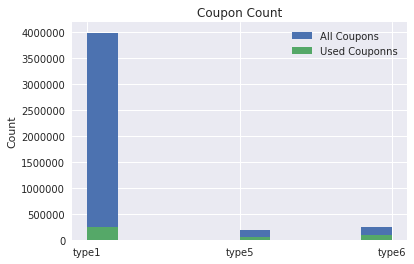

In [77]:
plt.hist(check_trainset["type"])
plt.hist(check_trainset[check_trainset["is_used"]==1]["type"])
plt.title('Coupon Count')
plt.ylabel('Count')
plt.legend(['All Coupons', 'Used Couponns'], loc='upper right')

In [120]:
total_1 = len(check_trainset[check_trainset["type"]=="type1"])
total_1_used = len(check_trainset[(check_trainset["type"]=="type1")&(check_trainset["is_used"]==1)])
print(total_1/len(check_trainset), total_1_used/total_1)

0.9016244095574253 0.059873187474435485


In [121]:
total_5 = len(check_trainset[check_trainset["type"]=="type5"])
total_5_used = len(check_trainset[(check_trainset["type"]=="type5")&(check_trainset["is_used"]==1)])
print(total_5/len(check_trainset), total_5_used/total_5)

0.042891512324393505 0.2721243719983763


In [122]:
total_6 = len(check_trainset[check_trainset["type"]=="type6"])
total_6_used = len(check_trainset[(check_trainset["type"]=="type6")&(check_trainset["is_used"]==1)])
print(total_6/len(check_trainset), total_6_used/total_6)

0.05548407811818122 0.40114108729317793


/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['STKaiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


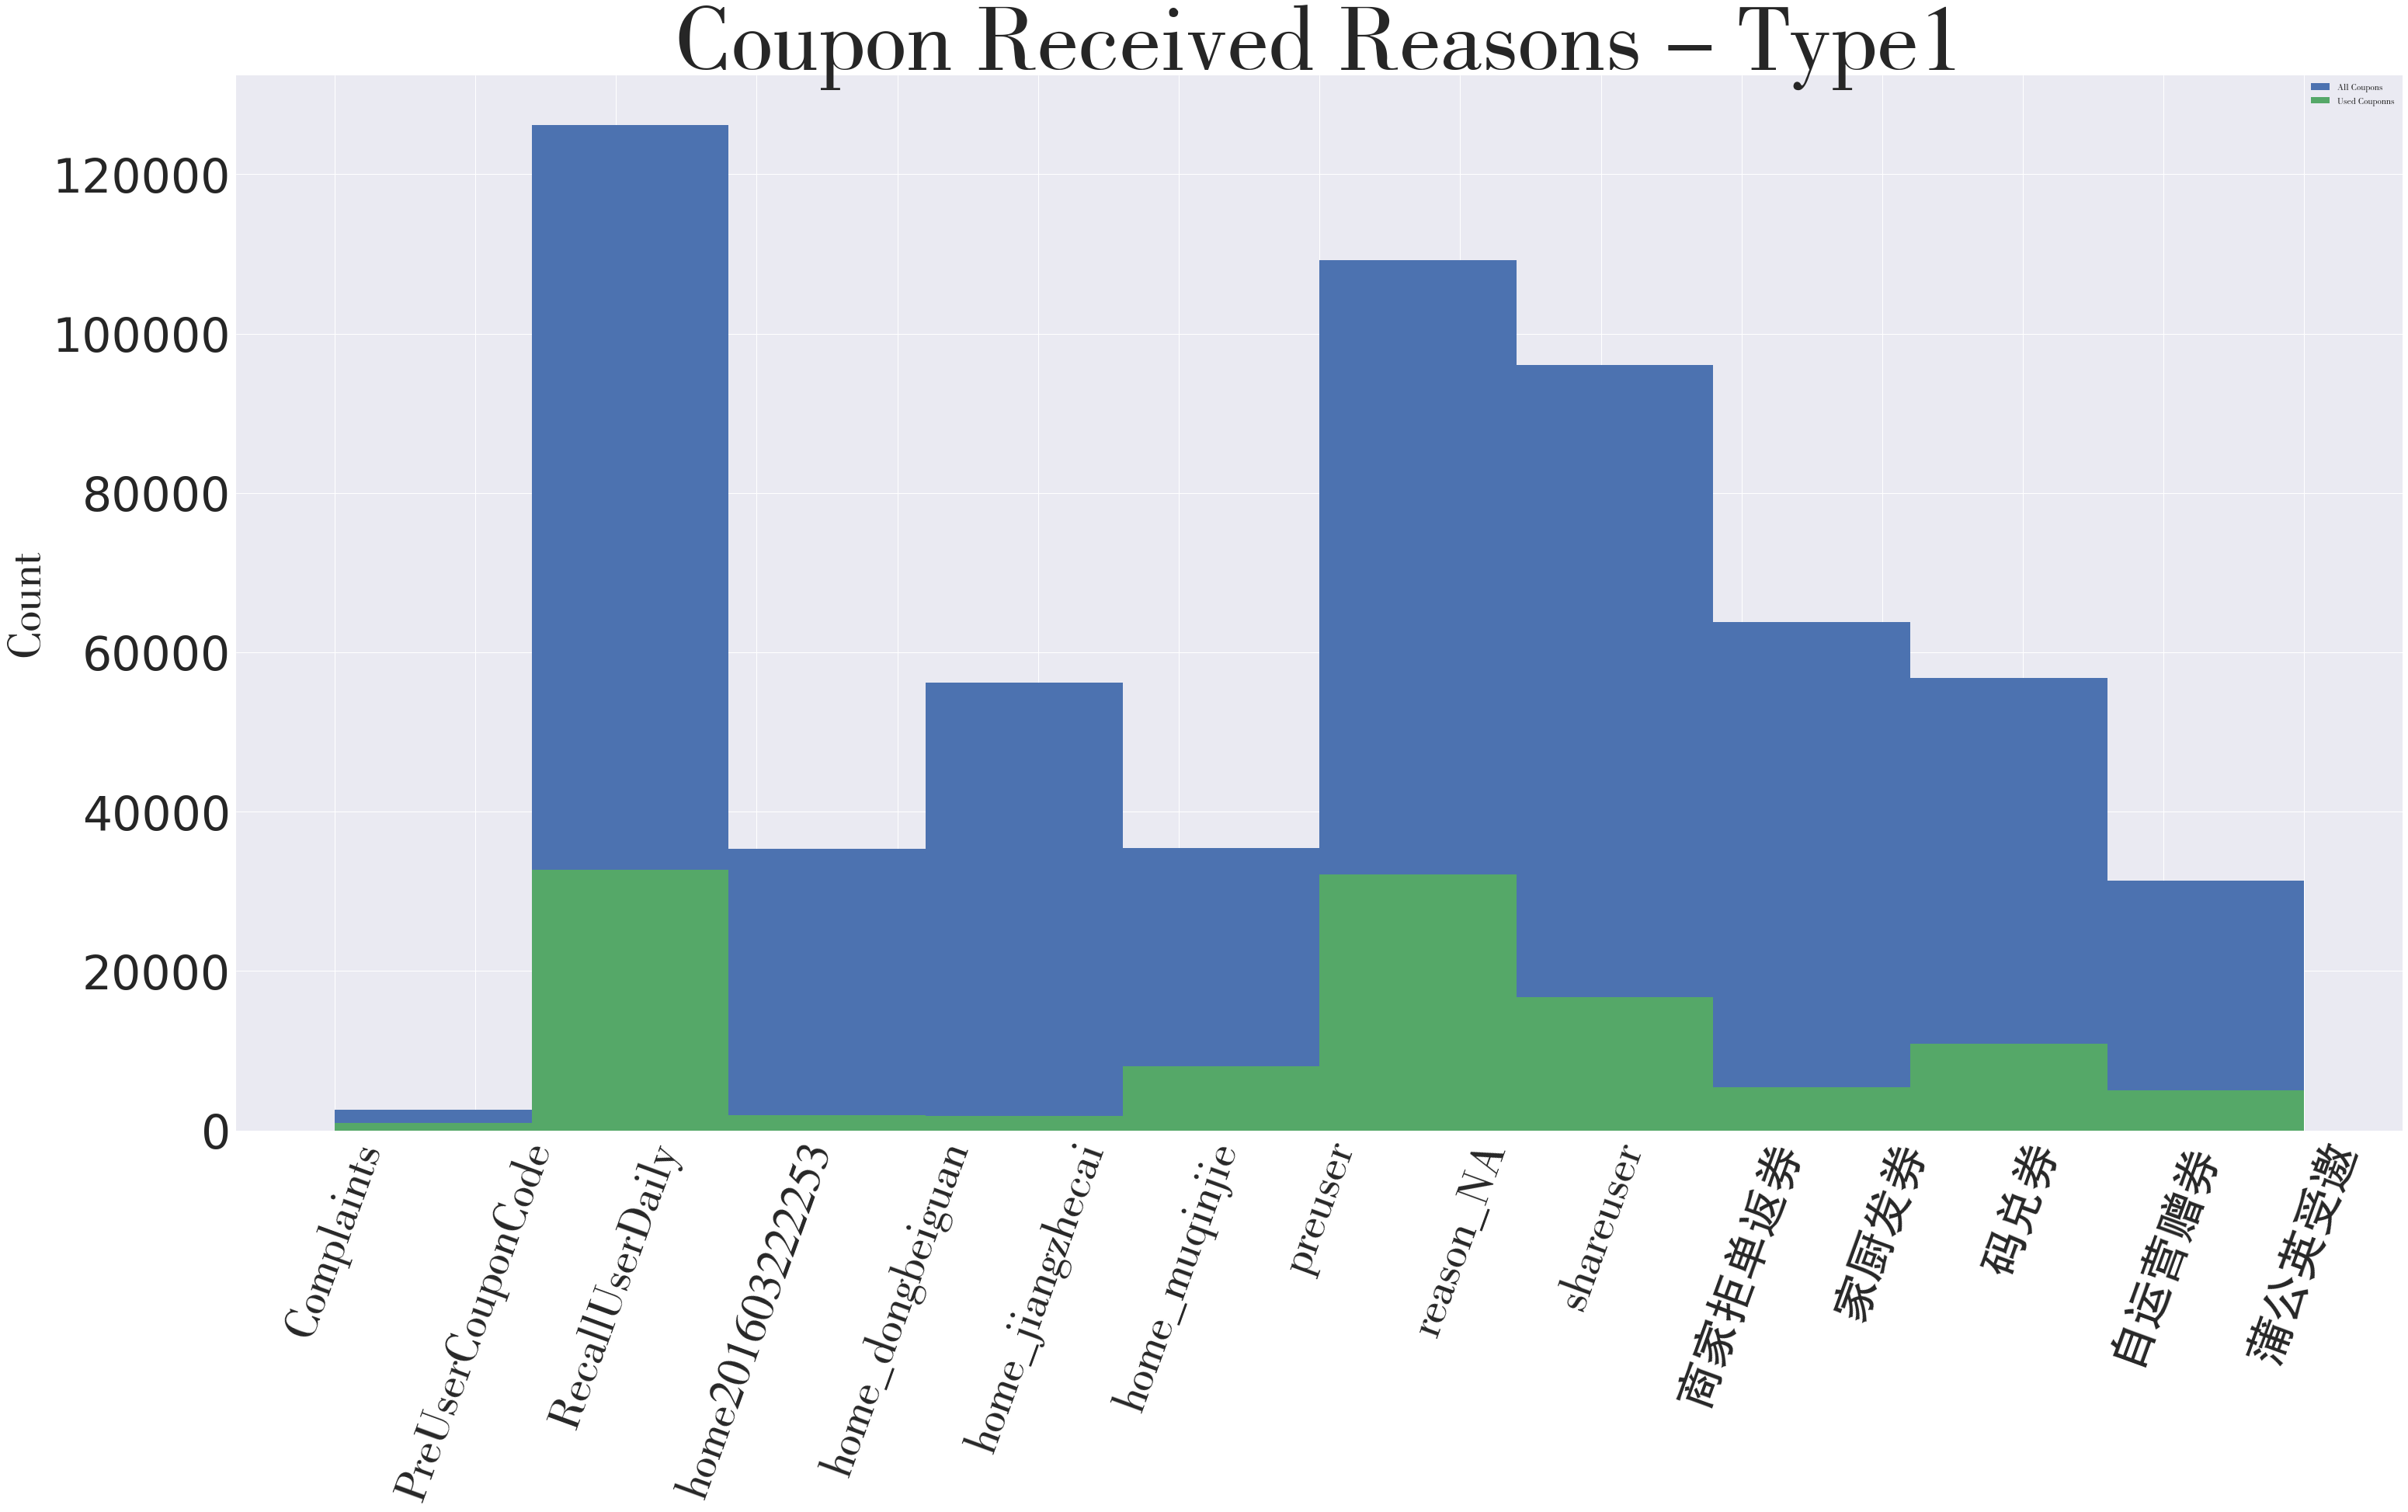

In [98]:
from pyplotz.pyplotz import PyplotZ
pltz = PyplotZ()
pltz.set_figure_size(50,25)
pltz.enable_chinese()
pltz.hist(check_trainset[(check_trainset["type"]=="type1")&(check_trainset["reason"]!="活动赠券")]["reason"])
pltz.hist(check_trainset[(check_trainset["type"]=="type1")&(check_trainset["is_used"]==1)&(check_trainset["reason"]!="活动赠券")]["reason"])
pltz.title('Coupon Received Reasons - Type1')
pltz.ylabel('Count')
pltz.xticks(rotation=70)
pltz.legend(['All Coupons', 'Used Couponns'], loc='upper right')
pltz.automate_font_size(scale=0.8)

In [ ]:
    reason_ = len(check_trainset[check_trainset["reason"]==i])
    reason_used = len(check_trainset[(check_trainset["reason"]==i)&(check_trainset["is_used"]==1)])
    print(reason_)

In [117]:
check_trainset["reason"].drop_duplicates()

0                  reason_NA
1                       活动赠券
45           RecallUserDaily
136                     家厨发券
243                      码兑券
293                shareuser
378                    自运营赠券
828                   商家拒单返券
2102                   蒲公英受邀
2103                 preuser
11957             Complaints
1071307     home_jiangzhecai
1703159     home201603222253
3189734        home_muqinjie
3900458    PreUserCouponCode
3920499     home_dongbeiguan
Name: reason, dtype: object

In [203]:
check_trainset[check_trainset["reason"]=="home_jiangzhecai"].groupby("coupon_effective_days")["home_jiangzhecai"].count()

coupon_effective_days
2.958333    47456
2.958333     8758
Name: home_jiangzhecai, dtype: int64

In [205]:
check_trainset[check_trainset["reason"]=="家厨发券"].groupby("coupon_effective_days")["家厨发券"].count()

coupon_effective_days
1.958333     28871
1.958333      1983
7.958333     15485
7.958333      2971
10.958330     2380
10.958333      432
15.958330      808
15.958333      153
30.958330     2122
30.958333      533
Name: 家厨发券, dtype: int64

In [206]:
1-(28871+1983)/(28871+1983+15485+2971+2380+432+808+153+2122+533)

0.44644587175714956

In [207]:
check_trainset[check_trainset["reason"]=="home_muqinjie"].groupby("coupon_effective_days")["home_muqinjie"].count()

coupon_effective_days
2.958333    30906
2.958333     4516
Name: home_muqinjie, dtype: int64

In [208]:
check_trainset[check_trainset["reason"]=="自运营赠券"].groupby("coupon_effective_days")["自运营赠券"].count()

coupon_effective_days
1.958333     6790
1.958333     1512
7.958333     8806
7.958333     1311
10.958330    1347
10.958333     295
15.958330    1446
15.958333     360
30.958330    1789
30.958333     265
Name: 自运营赠券, dtype: int64

In [209]:
check_trainset[check_trainset["reason"]=="自运营赠券"]["coupon_effective_days"].mean()

8.660811470865783

In [210]:
check_trainset[check_trainset["reason"]=="preuser"]["coupon_effective_days"].drop_duplicates()

2103     14.958333
30273    14.958330
Name: coupon_effective_days, dtype: float64

In [211]:
check_trainset[check_trainset["reason"]=="home_dongbeiguan"]["coupon_effective_days"].drop_duplicates()

3920499    2.958333
4066744    2.958333
Name: coupon_effective_days, dtype: float64

In [212]:
check_trainset[check_trainset["reason"]=="蒲公英受邀"]["coupon_effective_days"].drop_duplicates()

2102        6.958333
30272       6.958333
4066276    14.958330
4068673    14.958333
Name: coupon_effective_days, dtype: float64

In [213]:
check_trainset[check_trainset["reason"]=="Complaints"]["coupon_effective_days"].drop_duplicates()

11957      5.125000
48526      5.583333
560578     5.166667
569837     5.291667
570713     5.458333
588136     5.208333
595739     5.166667
816884     5.541667
824046     5.541667
944265     5.500000
1068759    5.291667
1104384    5.375000
1165328    5.250000
1176123    5.416667
1179425    5.208333
1232772    5.333333
1567338    5.583333
1605703    5.458333
3488932    5.416667
4148207    5.083333
Name: coupon_effective_days, dtype: float64

In [214]:
check_trainset[check_trainset["reason"]=="PreUserCouponCode"]["coupon_effective_days"].drop_duplicates()

3900458     6.958333
3900459    14.958330
Name: coupon_effective_days, dtype: float64

In [197]:
check_trainset[check_trainset["reason"]=="商家拒单返券"]["coupon_effective_days"].drop_duplicates()

828        15.458333
1100       15.625000
2313       15.250000
5311       15.875000
6799       15.541667
7856       15.500000
9439       15.000000
11106      15.208333
11261      15.583333
16802      15.083333
19011      15.708333
20219      15.166667
28166      15.125000
31172      15.541670
31875      15.458330
41162      15.583330
49006      15.166670
55717      15.416670
56102      15.708330
58812      15.208330
62528      15.083330
96669      15.666670
98683      15.375000
100384     15.333330
108586     15.291670
164647     15.791670
170515     15.958330
224093     15.916670
230416     15.041667
230609     15.416667
230825     15.666667
231097     15.333333
235891     15.041670
243149     15.291667
290901     15.958333
577715     15.750000
1189219    15.916667
1487099    15.833330
1603688    15.833333
3742294    15.791667
Name: coupon_effective_days, dtype: float64

In [201]:
check_trainset[check_trainset["reason"]=="码兑券"].groupby("coupon_effective_days")["码兑券"].count()

coupon_effective_days
0.958333     13674
0.958333      2158
2.958333     11117
2.958333      1802
3.958333      2261
3.958333       387
4.958333     15693
4.958333      2494
5.958333      2261
5.958333       387
8.958333       174
9.958333        20
11.958330      185
11.958333       10
12.958330        6
13.958330       65
13.958333        7
14.958330       54
14.958333       14
15.958330      807
15.958333      124
17.958330       78
17.958333       13
18.958330      430
18.958333       30
19.958330      492
19.958333       68
20.958330      111
20.958333       20
21.958330     1228
21.958333      186
22.958330      468
22.958333       60
23.958330       21
33.958330       32
33.958333        1
Name: 码兑券, dtype: int64

In [202]:
check_trainset[check_trainset["reason"]=="码兑券"]["coupon_effective_days"].mean()

4.565431857671131

In [200]:
check_trainset[check_trainset["reason"]=="RecallUserDaily"].groupby("coupon_effective_days")["RecallUserDaily"].count()

coupon_effective_days
5.958333    112235
5.958333     13904
Name: RecallUserDaily, dtype: int64

In [198]:
check_trainset[check_trainset["reason"]=="shareuser"].groupby("coupon_effective_days")["shareuser"].count()

coupon_effective_days
6.958333     35798
6.958333      2614
14.958330    53697
14.958333     3921
Name: shareuser, dtype: int64

In [190]:
check_trainset[check_trainset["reason"]=="活动赠券"].groupby("coupon_effective_days")["活动赠券"].count()

coupon_effective_days
0.958333      732612
0.958333      100561
1.958333     1875230
1.958333      196881
2.958333      485261
2.958333       39760
3.958333           2
6.958333        4017
6.958333          60
7.958333           3
12.958330       2628
12.958333         30
13.958333          2
Name: 活动赠券, dtype: int64

In [196]:
check_trainset[check_trainset["reason"]=="reason_NA"].groupby("coupon_effective_days")["reason_NA"].count()

coupon_effective_days
0.958333     186330
0.958333      32958
1.958333      30161
1.958333       5114
2.958333       4791
2.958333        906
4.958333          4
5.166667          1
5.208333          1
5.250000          5
5.291667          3
5.333333          1
5.416667          1
5.416667          2
5.500000          6
5.541667          2
5.583333          2
5.958333          6
6.958333      16914
6.958333         18
7.958333     132914
7.958333      22739
14.958330     36041
14.958333        20
20.958333         1
29.958330        45
29.958333        55
30.958333         4
Name: reason_NA, dtype: int64

In [118]:
for i in check_trainset["reason"].drop_duplicates():
    reason_ = len(check_trainset[(check_trainset["reason"]==i)])
#     reason_used = len(check_trainset[(check_trainset["type"]=="type1")&(check_trainset["reason"]==i)&(check_trainset["is_used"]==1)])
    print(reason_/len(check_trainset))

0.10605807083275863
0.777167594114681
0.028521909404797707
0.012603193194845484
0.01287453109419269
0.02171381539526018
0.005408894908570433
0.0018251996029422072
0.0016804860566236974
0.0028490479431456657
0.00011577083705480799
0.012710823894919876
0.005816580102339611
0.008009442558897283
0.0004725801746963842
0.002172059884274386


In [152]:
recalled_users = check_trainset[check_trainset["reason"] == "RecallUserDaily"]["user_id"].drop_duplicates()
print(len(recalled_users))
print(len(check_trainset[check_trainset["reason"] == "RecallUserDaily"]))
print(93906/368201)
print(126139/93906)

93906
126139
0.25504004606179775
1.3432475028219708


In [151]:
len(check_trainset["user_id"].drop_duplicates())

368201

In [153]:
shared_users = check_trainset[check_trainset["reason"] == "shareuser"]["user_id"].drop_duplicates()
print(len(shared_users))
print(len(check_trainset[check_trainset["reason"] == "shareuser"]))
print(13091/368201)
print(96030/13091)

13091
96030
0.035553950152226635
7.335574058513482


Text(0.5,0,'Order Count')

/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['STKaiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


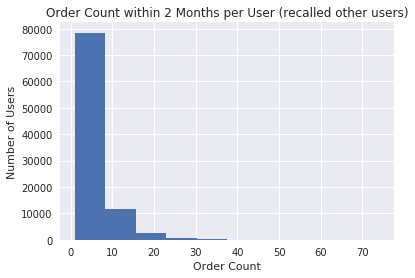

In [174]:
plt.hist(check_trainset[check_trainset["user_id"].isin(recalled_users)][["user_id", "order_count"]].groupby("user_id")["order_count"].max()+1, bins=10)
plt.title('Order Count within 2 Months per User (recalled other users)')
plt.ylabel('Number of Users')
plt.xlabel('Order Count')
# plt.legend(['All Coupons', 'Used Couponns'], loc='upper right')

Text(0.5,0,'Order Count')

/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['STKaiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


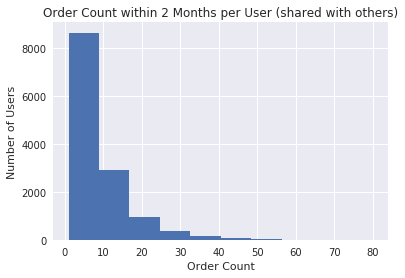

In [175]:
plt.hist(check_trainset[check_trainset["user_id"].isin(shared_users)][["user_id", "order_count"]].groupby("user_id")["order_count"].max()+1, bins=10)
plt.title('Order Count within 2 Months per User (shared with others)')
plt.ylabel('Number of Users')
plt.xlabel('Order Count')
# plt.legend(['All Coupons', 'Used Couponns'], loc='upper right')

In [232]:
a = check_trainset[check_trainset["user_id"].isin(recalled_users)][["user_id", "order_count"]].groupby("user_id")["order_count"].max()+1

In [234]:
len(a[a==1])/len(a)

0.016846633867910462

In [239]:
len(a[a<=3])/len(a)

0.5036845355994292

In [236]:
len(a[a>=5])/len(a)

0.39042233723084785

In [246]:
print(a.mean())
print(a.median())

5.178518944476392
3.0


In [233]:
b = check_trainset[check_trainset["user_id"].isin(shared_users)][["user_id", "order_count"]].groupby("user_id")["order_count"].max()+1

In [242]:
len(b[(b>=6) & (b<=9)])/len(b)

0.22878313345046214

In [243]:
len(b[b>=15])/len(b)

0.1530058819035979

In [247]:
print(b.mean())
print(b.median())

8.248032999770835
6.0


In [165]:
check_trainset[check_trainset["user_id"].isin(recalled_users)][["user_id", "order_count"]].groupby("user_id")["order_count"].max().mean()+1

5.178518944476392

In [177]:
check_trainset[check_trainset["user_id"].isin(shared_users)][["user_id", "order_count"]].groupby("user_id")["order_count"].max().median()+1

6.0

In [176]:
check_trainset[check_trainset["user_id"].isin(shared_users)][["user_id", "order_count"]].groupby("user_id")["order_count"].max().mean()+1

8.248032999770835

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 <a list of 38 Text xticklabel objects>)

/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['STKaiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


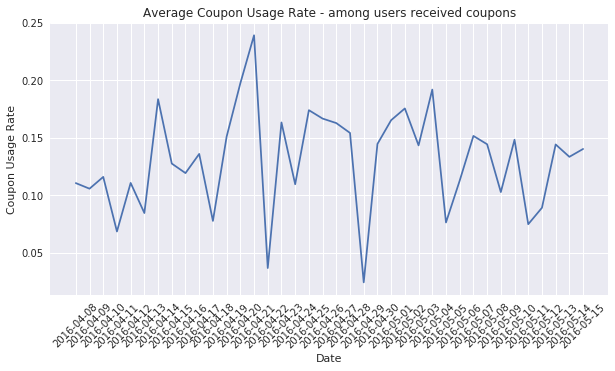

In [257]:
plt.figure(figsize=(10,5))
plt.plot(check_trainset[["start_time", "coupon_usage_rate"]].groupby("start_time")["coupon_usage_rate"].mean())
# plt.plot(check_trainset[["start_time", "coupon_usage_rate"]].groupby("start_time")["coupon_usage_rate"].median())
plt.title('Average Coupon Usage Rate - among users received coupons')
plt.ylabel('Coupon Usage Rate')
plt.xlabel('Date')
plt.xticks(rotation=45)
# plt.legend(['Type6', 'Type1'], loc='upper left')

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 9 Text xticklabel objects>)

/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['STKaiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


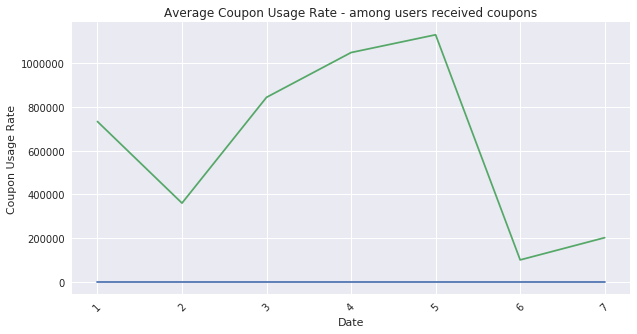

In [261]:
plt.figure(figsize=(10,5))
plt.plot(check_trainset[["weekday", "coupon_usage_rate"]].groupby("weekday")["coupon_usage_rate"].mean())
plt.plot(check_trainset[["weekday", "coupon_id"]].groupby("weekday")["coupon_id"].count())
plt.title('Average Coupon Usage Rate - among users received coupons')
plt.ylabel('Coupon Usage Rate')
plt.xlabel('Date')
plt.xticks(rotation=45)
# plt.legend(['Type6', 'Type1'], loc='upper left')

In [262]:
check_trainset[["weekday", "coupon_usage_rate"]].groupby("weekday")["coupon_usage_rate"].mean()

weekday
1    0.089524
2    0.147109
3    0.138696
4    0.119527
5    0.087292
6    0.139402
7    0.128759
Name: coupon_usage_rate, dtype: float64

In [266]:
check_trainset[["weekday", "coupon_id"]].groupby("weekday")["coupon_id"].count()

weekday
1     733901
2     360464
3     844718
4    1049649
5    1130976
6     100522
7     202300
Name: coupon_id, dtype: int64

In [271]:
orig_data=orig_data.sort_values("send_time")

In [276]:
order_data = orig_data[orig_data["order_no"].notna()]

In [278]:
order_data = order_data[order_data["send_time"] >= "2016-04-08"]

In [282]:
order_data["send_time"] = order_data["send_time"].apply(lambda x:x[:10])

/Users/meif/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [286]:
order_data["weekday"] = order_data["send_time"].apply(lambda x:datetime.strptime(x, "%Y-%m-%d").weekday()+1)

/Users/meif/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['STKaiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


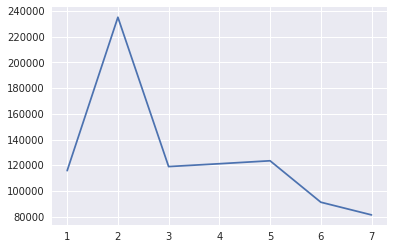

In [289]:
plt.plot(order_data.groupby("weekday")["coupon_id"].count())

In [290]:
for i in order_data.groupby("weekday")["coupon_id"].count():
    print(i)

115821
235175
119003
121215
123515
91285
81402


In [274]:
check_trainset

,user_coupon,user_id,coupon_id,start_time,is_used,end_time,coupon_effective_days,money,max_money,covers_mon,covers_tue,covers_wed,covers_thu,covers_fri,covers_sat,covers_sun,type,type1,type5,type6,type_NA,reason,Complaints,Eventsoperation,NewUserCouponPackageByBD,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,reason_NA,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,sex,sex_1,sex_2,sex_NA,age,age_0,age_60,age_70,age_80,age_90,age_NA,city_id,city1,city2,city3,city4,city5,city_NA,distance_median,distance_std,user_longitude_median,user_longitude_std,user_latitude_median,user_latitude_std,worth_money_median,worth_money_std,kitchen_entropy,AppVerLast,CoupUseLast,coupon_count,coupon_count_used,coupon_count_used_weekend,order_count,BiWeeklyOrderCount,order_coupon_count,order_count_weekend,coupon_usage_rate,order_coupon_usage_rate,coupon_used_weekend_perc,order_weekend_perc,AppVerLast_2.1,AppVerLast_2.2,AppVerLast_2.3,AppVerLast_2.4,AppVerLast_2.5,AppVerLast_2.6,AppVerLast_2.7,AppVerLast_2.8,Unnamed: 0,coupon_type1_usage_rate,coupon_type6_usage_rate,InterCoup,InterOrder,Recency,weekday
0,14_13159484,14,13159484,2016-04-08,1.0,2016-04-08 23:59:59,0.958333,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type5,0,1,0,0,reason_NA,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,sex_NA,0,0,1,age_NA,0,0,0,0,0,1,city3,0,0,1,0,0,0,2156.0,833.795758,120.182450,1.573879,30.263791,3.930686,8.0,0.000000,1.242453,AppVerLast_2.6,0.0,5.0,1.0,0.0,6.0,6.0,1.0,1.0,0.200000,0.166667,0.0,0.166667,0,0,0,0,0,1,0,0,0,0.333333,0.0,1500.0,25.4,6.0,5
1,59_13161460,59,13161460,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_2,0,1,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,857.0,0.000000,116.277084,0.000000,39.957024,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,13.0,0.0,0.0,2.0,2.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,1,0.000000,0.0,-0.0,120.0,1500.0,5
2,59_13162460,59,13162460,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_2,0,1,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,857.0,0.000000,116.277084,0.000000,39.957024,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,13.0,0.0,0.0,2.0,2.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,2,0.000000,0.0,-0.0,120.0,1500.0,5
3,60_13161461,60,13161461,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_90,0,0,0,0,1,0,city_NA,0,0,0,0,0,1,1365.0,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,3,0.000000,0.0,-0.0,-0.0,1500.0,5
4,60_13162461,60,13162461,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_90,0,0,0,0,1,0,city_NA,0,0,0,0,0,1,1365.0,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,4,0.000000,0.0,-0.0,-0.0,1500.0,5
5,62_13161462,62,13161462,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,1365.0,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,0,0,0,1,0,0,5,0.000000,0.0,-0.0,-0.0,1500.0,5
6,62_13162462,62,13162462,2016-04-08,0.0,2016-04-08 23:59:59,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,type1,1,0,0,0,活动赠券,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,sex_1,1,0,0,age_80,0,0,0,1,0,0,city_NA,0,0,0,0,0,1,1365.0,0.000000,116.430900,0.000000,39.917430,0.000000,8.0,0.000000,0.000000,AppVerLast_2.6,0.0,1

/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['STKaiti'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


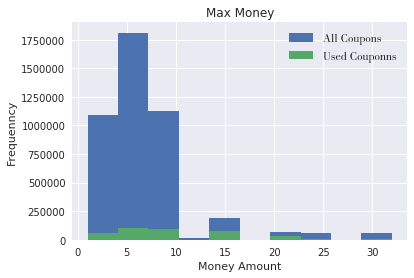

In [300]:
plt.hist(check_trainset["max_money"])
plt.hist(check_trainset[check_trainset["is_used"] == 1]["max_money"])
plt.title('Max Money')
plt.ylabel('Frequenncy')
plt.xlabel('Money Amount')
pltz.legend(['All Coupons', 'Used Couponns'], loc='upper right')

In [307]:
check_trainset[check_trainset["max_money"]>=25].groupby("reason")["reason"].count()

reason
home201603222253    25724
home_dongbeiguan     9606
home_jiangzhecai    56214
home_muqinjie       35422
家厨发券                   12
Name: reason, dtype: int64

In [310]:
56214/(56214+25724+35422+9606+12)

0.44270661059396116

In [311]:
check_trainset[check_trainset["reason"]=="home_jiangzhecai"]["coupon_effective_days"]

1071307    2.958333
1071308    2.958333
1073705    2.958333
1073706    2.958333
1085798    2.958333
1085799    2.958333
1114966    2.958333
1114967    2.958333
1114968    2.958333
1114969    2.958333
1114976    2.958333
1114977    2.958333
1114979    2.958333
1114980    2.958333
1114981    2.958333
1114982    2.958333
1114985    2.958333
1114986    2.958333
1114988    2.958333
1114989    2.958333
1114990    2.958333
1114991    2.958333
1114994    2.958333
1114995    2.958333
1114998    2.958333
1114999    2.958333
1115000    2.958333
1115001    2.958333
1115007    2.958333
1115008    2.958333
             ...   
1477508    2.958333
1477509    2.958333
1477513    2.958333
1477514    2.958333
1477515    2.958333
1477516    2.958333
1477526    2.958333
1477527    2.958333
1477528    2.958333
1477529    2.958333
1477530    2.958333
1477531    2.958333
1477541    2.958333
1477542    2.958333
1477543    2.958333
1477544    2.958333
1477551    2.958333
1477552    2.958333
1477571    2.958333


In [9]:
dataset_180305_UserFeatures = dataset_180305.loc[:,["user_coupon","user_id","coupon_id","start_time","is_used",
                                                    "sex_1","sex_2",
                                                    "age_60","age_70","age_80","age_90","age_0",
                                                    "city1","city2","city3","city4","city5",
                                                    "AppVerLast_2.1","AppVerLast_2.2","AppVerLast_2.3","AppVerLast_2.4","AppVerLast_2.5","AppVerLast_2.7","AppVerLast_2.8",
                                                    "kitchen_entropy",
                                                    "distance_median","distance_std",
                                                    "user_longitude_median","user_longitude_std","user_latitude_median","user_latitude_std"]]

In [10]:
dataset_180305_CouponFeatures = dataset_180305.loc[:,["user_coupon",
                                                      "coupon_effective_days",
                                                      "money","max_money",
                                                      "covers_mon","covers_tue","covers_wed","covers_thu","covers_fri","covers_sat","covers_sun",
                                                      "type1","type6",
                                                      "Complaints","Eventsoperation","NewUserCouponPackageByBD","PreUserCouponCode","RecallUserDaily","home201603222253","home_dongbeiguan","home_jiangzhecai","home_muqinjie","home_xiangcaiguan","preuser","shareuser","商家拒单返券","家厨发券","活动赠券","码兑券","自运营赠券","蒲公英受邀"]]

In [11]:
dataset_180305_RFM = dataset_180305.loc[:,["user_coupon",
                                           "WeeklyCouponUsedCount", "BiWeeklyCouponUsedCount",
                                           "WeeklyOrderCount","BiWeeklyOrderCount",
                                           "coupon_usage_rate","order_coupon_usage_rate",
                                           "coupon_type1_usage_rate","coupon_type6_usage_rate",
                                           "coupon_used_weekend_perc","order_weekend_perc",
                                           "worth_money_median","worth_money_std",
                                           "InterCoup","InterOrder","Recency","CoupUseLast"]]

In [12]:
dataset_180305_all = pd.merge(dataset_180305_UserFeatures, dataset_180305_CouponFeatures, on="user_coupon")

In [13]:
dataset_180305_all = pd.merge(dataset_180305_all, dataset_180305_RFM, on="user_coupon")

In [14]:
print(len(dataset_180305_all))
dataset_180305_all

5484528


,user_coupon,user_id,coupon_id,start_time,is_used,sex_1,sex_2,age_60,age_70,age_80,age_90,age_0,city1,city2,city3,city4,city5,AppVerLast_2.1,AppVerLast_2.2,AppVerLast_2.3,AppVerLast_2.4,AppVerLast_2.5,AppVerLast_2.7,AppVerLast_2.8,kitchen_entropy,distance_median,distance_std,user_longitude_median,user_longitude_std,user_latitude_median,user_latitude_std,coupon_effective_days,money,max_money,covers_mon,covers_tue,covers_wed,covers_thu,covers_fri,covers_sat,covers_sun,type1,type6,Complaints,Eventsoperation,NewUserCouponPackageByBD,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,coupon_count_used,order_count,BiWeeklyOrderCount,coupon_usage_rate,order_coupon_usage_rate,coupon_type1_usage_rate,coupon_type6_usage_rate,coupon_used_weekend_perc,order_weekend_perc,worth_money_median,worth_money_std,InterCoup,InterOrder,Recency,CoupUseLast
0,14_13159484,14,13159484,2016-04-08,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.242453,2156.00,833.795758,120.182450,1.573879,30.263791,3.930686,0.958333,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,6.0,6.0,0.200000,0.166667,0.333333,0.0,0.0,0.166667,8.0,0.000000,1500.0,25.4,6.0,0.0
1,59_13161460,59,13161460,2016-04-08,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,857.00,0.000000,116.277084,0.000000,39.957024,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,2.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,120.0,1500.0,0.0
2,59_13162460,59,13162460,2016-04-08,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,857.00,0.000000,116.277084,0.000000,39.957024,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,2.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,120.0,1500.0,0.0
3,60_13161461,60,13161461,2016-04-08,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,-0.0,1500.0,0.0
4,60_13162461,60,13162461,2016-04-08,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,-0.0,1500.0,0.0
5,62_13161462,62,13161462,2016-04-08,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,-0.0,1500.0,0.0
6,62_13162462,62,13162462,2016-04-08,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,-0.0,1500.0,0.0
7,64_13161463,64,13161463,2016-04-08,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1301.00,0.000000,114.077638,0.000000,22.539314,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,1500.0,1500.0,0.0
8,64_13162463,64,13162463,2016-04-08,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1301.00,0.000000,114.077638,0.000000,22.539314,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,1500.0,1500.0,0.0
9,66_13161464,66,13161464,2016-04-08,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1751.00,0.000000,116.483136,0.000000,39.997367,0.000000,0.958333,6.0,6.0,0

In [43]:
dataset_180305_all.to_csv("dataset_180305v2.csv")

## 1.3 Split Train Test Data

In [9]:
dataset_180305_all = pd.read_csv("Dataset/dataset_180305v2.csv").iloc[:,1:]
print(len(dataset_180305_all))
dataset_180305_all

5484528


,user_coupon,user_id,coupon_id,start_time,is_used,sex_1,sex_2,age_60,age_70,age_80,age_90,age_0,city1,city2,city3,city4,city5,AppVerLast_2.1,AppVerLast_2.2,AppVerLast_2.3,AppVerLast_2.4,AppVerLast_2.5,AppVerLast_2.7,AppVerLast_2.8,kitchen_entropy,distance_median,distance_std,user_longitude_median,user_longitude_std,user_latitude_median,user_latitude_std,coupon_effective_days,money,max_money,covers_mon,covers_tue,covers_wed,covers_thu,covers_fri,covers_sat,covers_sun,type1,type6,Complaints,Eventsoperation,NewUserCouponPackageByBD,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,coupon_usage_rate,order_coupon_usage_rate,coupon_type1_usage_rate,coupon_type6_usage_rate,coupon_used_weekend_perc,order_weekend_perc,worth_money_median,worth_money_std,InterCoup,InterOrder,Recency,CoupUseLast,WeeklyCouponUsedCount,BiWeeklyCouponUsedCount,WeeklyOrderCount,BiWeeklyOrderCount
0,14_13159484,14,13159484,2016-04-08,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.242453,2156.00,833.795758,120.182450,1.573879,30.263791,3.930686,0.958333,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.200000,0.166667,0.333333,0.0,0.0,0.166667,8.0,0.000000,1500.0,25.4,6.0,0.0,1.0,1.0,6.0,6.0
1,59_13161460,59,13161460,2016-04-08,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,857.00,0.000000,116.277084,0.000000,39.957024,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,120.0,1500.0,0.0,0.0,0.0,2.0,2.0
2,59_13162460,59,13162460,2016-04-08,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,857.00,0.000000,116.277084,0.000000,39.957024,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,120.0,1500.0,0.0,0.0,0.0,2.0,2.0
3,60_13161461,60,13161461,2016-04-08,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,-0.0,1500.0,0.0,0.0,0.0,0.0,0.0
4,60_13162461,60,13162461,2016-04-08,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,-0.0,1500.0,0.0,0.0,0.0,0.0,0.0
5,62_13161462,62,13161462,2016-04-08,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,-0.0,1500.0,0.0,0.0,0.0,0.0,0.0
6,62_13162462,62,13162462,2016-04-08,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.00,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,-0.0,1500.0,0.0,0.0,0.0,0.0,0.0
7,64_13161463,64,13161463,2016-04-08,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1301.00,0.000000,114.077638,0.000000,22.539314,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,1500.0,1500.0,0.0,0.0,0.0,1.0,1.0
8,64_13162463,64,13162463,2016-04-08,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1301.00,0.000000,114.077638,0.000000,22.539314,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.000000,-0.0,1500.0,1500.0,0.0,0.0,0.0,1.0,1.0
9,66_13161464,66,13161464,2016-04-08,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1751.

In [14]:
split_date = dataset_180305_all.iloc[int(len(dataset_180305_all) * 0.80),]["start_time"]
split_date

'2016-05-15'

In [15]:
trainset = dataset_180305_all[dataset_180305_all["start_time"] <= split_date]
testset = dataset_180305_all[dataset_180305_all["start_time"] > split_date]

In [16]:
# check label
print(len(trainset[trainset['is_used'] == 1]) / len(trainset))
print(len(testset[testset['is_used'] == 1]) / len(testset))

0.08791189658408197
0.15720839398944253


In [47]:
# trainset.to_csv("trainset_180314.csv")
# testset.to_csv("testset_180314.csv")

In [48]:
trainset.columns

Index(['user_coupon', 'user_id', 'coupon_id', 'start_time', 'is_used', 'sex_1',
       'sex_2', 'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 'city1',
       'city2', 'city3', 'city4', 'city5', 'AppVerLast_2.1', 'AppVerLast_2.2',
       'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7',
       'AppVerLast_2.8', 'kitchen_entropy', 'distance_median', 'distance_std',
       'user_longitude_median', 'user_longitude_std', 'user_latitude_median',
       'user_latitude_std', 'coupon_effective_days', 'money', 'max_money',
       'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri',
       'covers_sat', 'covers_sun', 'type1', 'type6', 'Complaints',
       'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode',
       'RecallUserDaily', 'home201603222253', 'home_dongbeiguan',
       'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser',
       'shareuser', '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀',
       'coupon_usage_rat

## 2. Bin-Bin Plot

In [ ]:
trainset = pd.read_csv("trainset_180314.csv").iloc[:,1:]

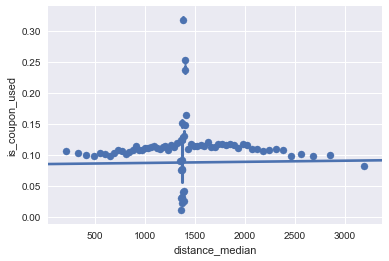

In [23]:
data1 = pd.Series(trainset[trainset["distance_median"] > 1]["distance_median"], name="distance_median")
data2 = pd.Series(trainset[trainset["distance_median"] > 1]["is_used"], name="is_coupon_used")
sns.regplot(data1, data2, x_estimator=np.mean, x_bins=100)

In [ ]:
data1 = pd.Series((trainset[trainset["distance_median"] > 1]["distance_median"])**2, name="distance_median")
data2 = pd.Series(trainset[trainset["distance_median"] > 1]["is_used"], name="is_coupon_used")
sns.regplot(data1, data2, x_estimator=np.mean, x_bins=100)

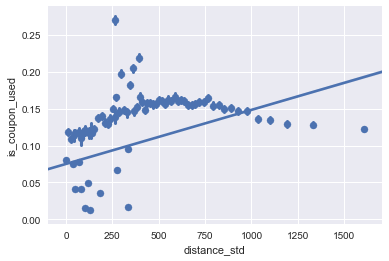

In [4]:
data9 = pd.Series(trainset[trainset["distance_std"] > 0]["distance_std"], name="distance_std")
data10 = pd.Series(trainset[trainset["distance_std"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data9, data10, x_estimator=np.mean, x_bins=100)

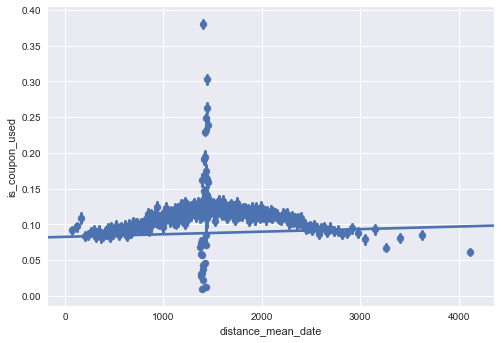

In [18]:
a = dataset_new[(dataset_new["distance_mean_date"] > 0)&(dataset_new["start_time"] <= '2016-05-15')]
data9 = pd.Series(a["distance_mean_date"], name="distance_mean_date")
data10 = pd.Series(a["is_used"], name="is_coupon_used")
sns.regplot(data9, data10, x_estimator=np.mean, x_bins=500)

In [ ]:
data3 = pd.Series(trainset[trainset["create_send_mean"] > 1]["create_send_mean"], name="create_send_min")
data4 = pd.Series(trainset[trainset["create_send_mean"] > 1]["is_used"], name="Is Used")
sns.regplot(data3, data4, x_estimator=np.mean, x_bins=500)

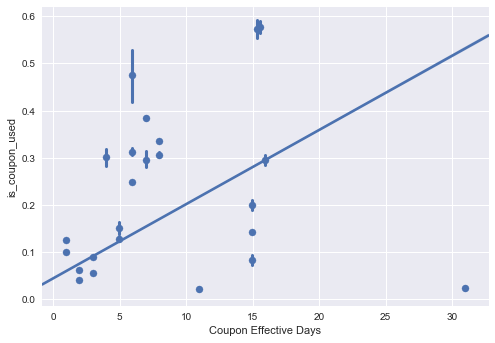

In [6]:
data5 = pd.Series(trainset["coupon_effective_days"], name="Coupon Effective Days")
data6 = pd.Series(trainset["is_used"], name="is_coupon_used")
sns.regplot(data5, data6, x_estimator=np.mean, x_bins=1000)

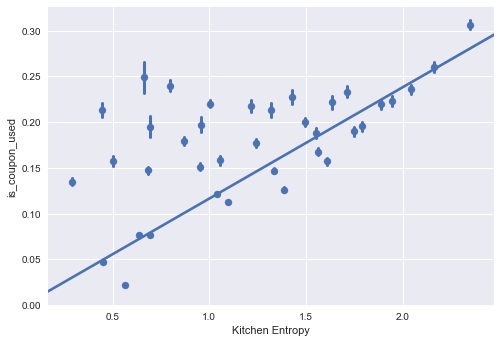

In [5]:
data7 = pd.Series(trainset[trainset["kitchen_entropy"] > 0]["kitchen_entropy"], name="Kitchen Entropy")
data8 = pd.Series(trainset[trainset["kitchen_entropy"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data7, data8, x_estimator=np.mean, x_bins=100)

In [3]:
trainset[trainset["kitchen_entropy"] > 0]["kitchen_entropy"].describe()

count    2.551841e+06
mean     9.086140e-01
std      4.536515e-01
min      9.221606e-02
25%      6.365142e-01
50%      6.931472e-01
75%      1.098612e+00
max      4.050453e+00
Name: kitchen_entropy, dtype: float64

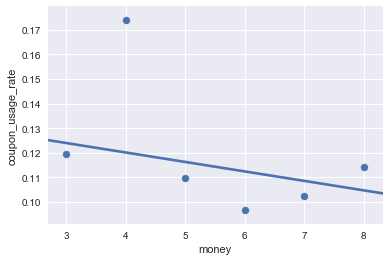

In [7]:
data11 = pd.Series(trainset["money"], name="money")
data12 = pd.Series(trainset["coupon_usage_rate"], name="coupon_usage_rate")
sns.regplot(data11, data12, x_bins=30)

In [4]:
ttest_ind(trainset[trainset["covers_tuesday"]==1].loc[:,["coupon_usage_rate"]],trainset[trainset["covers_tuesday"]==0].loc[:,["coupon_usage_rate"]],equal_var=False)

Ttest_indResult(statistic=array([102.48569669]), pvalue=array([0.]))

In [5]:
ttest_ind(trainset[trainset["CoupUseLast"]==1].loc[:,["coupon_usage_rate"]],trainset[trainset["CoupUseLast"]==0].loc[:,["coupon_usage_rate"]],equal_var=False)

Ttest_indResult(statistic=array([794.46691278]), pvalue=array([0.]))

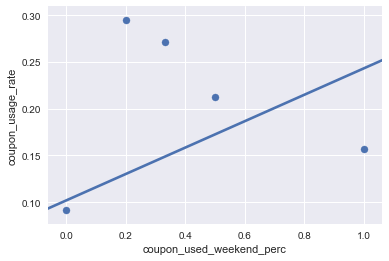

In [6]:
data13 = pd.Series(trainset["coupon_used_weekend_perc"], name="coupon_used_weekend_perc")
data14 = pd.Series(trainset["coupon_usage_rate"], name="coupon_usage_rate")
sns.regplot(data13, data14, x_bins=30)

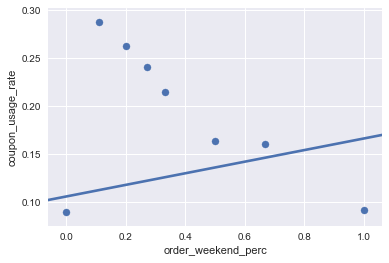

In [7]:
data15 = pd.Series(trainset["order_weekend_perc"], name="order_weekend_perc")
data16 = pd.Series(trainset["coupon_usage_rate"], name="coupon_usage_rate")
sns.regplot(data15, data16, x_bins=30)

[Text(0,0,'reason_NA'),
 Text(0,0,'活动赠券'),
 Text(0,0,'RecallUserDaily'),
 Text(0,0,'家厨发券'),
 Text(0,0,'码兑券'),
 Text(0,0,'shareuser'),
 Text(0,0,'自运营赠券'),
 Text(0,0,'商家拒单返券'),
 Text(0,0,'蒲公英受邀'),
 Text(0,0,'preuser'),
 Text(0,0,'Complaints'),
 Text(0,0,'home_jiangzhecai'),
 Text(0,0,'home201603222253'),
 Text(0,0,'home_muqinjie'),
 Text(0,0,'PreUserCouponCode'),
 Text(0,0,'home_dongbeiguan'),
 Text(0,0,'NewUserCouponPackageByBD'),
 Text(0,0,'Eventsoperation'),
 Text(0,0,'home_xiangcaiguan')]

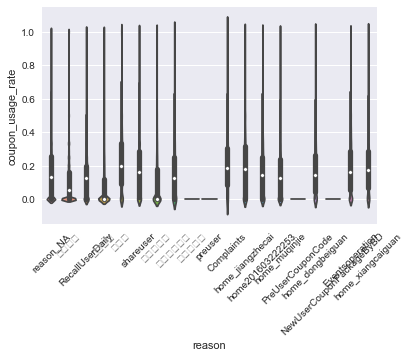

In [16]:
data17 = pd.Series(dataset_180305[dataset_180305['reason'].isnull()==False]['reason'], name='reason')
data18 = pd.Series(dataset_180305[dataset_180305['reason'].isnull()==False]["coupon_usage_rate"], name="coupon_usage_rate")
g = sns.violinplot(data17, data18)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

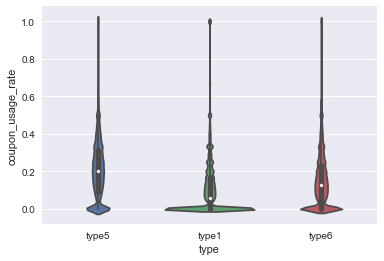

In [17]:
data19 = pd.Series(dataset_180305[dataset_180305['type'].isnull()==False]['type'], name='type')
data20 = pd.Series(dataset_180305[dataset_180305['type'].isnull()==False]["coupon_usage_rate"], name="coupon_usage_rate")
sns.violinplot(data19, data20)

[Text(0,0,'AppVerLast_2.6'),
 Text(0,0,'AppVerLast_2.4'),
 Text(0,0,'AppVerLast_2.7'),
 Text(0,0,'AppVerLast_2.5'),
 Text(0,0,'AppVerLast_2.3'),
 Text(0,0,'AppVerLast_2.1'),
 Text(0,0,'AppVerLast_2.2'),
 Text(0,0,'AppVerLast_2.8')]

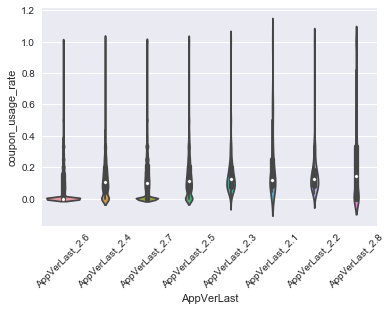

In [20]:
data21 = pd.Series(dataset_180305[dataset_180305['AppVerLast'].isnull()==False]['AppVerLast'], name='AppVerLast')
data22 = pd.Series(dataset_180305[dataset_180305['AppVerLast'].isnull()==False]["coupon_usage_rate"], name="coupon_usage_rate")
g = sns.violinplot(data21, data22)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

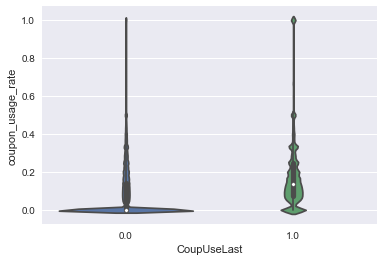

In [22]:
data23 = pd.Series(dataset_180305[dataset_180305['CoupUseLast'].isnull()==False]['CoupUseLast'], name='CoupUseLast')
data24 = pd.Series(dataset_180305[dataset_180305['CoupUseLast'].isnull()==False]["coupon_usage_rate"], name="coupon_usage_rate")
sns.violinplot(data23, data24)

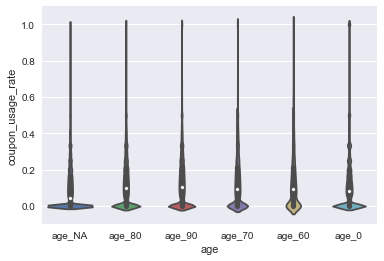

In [23]:
data25 = pd.Series(dataset_180305[dataset_180305['age'].isnull()==False]['age'], name='age')
data26 = pd.Series(dataset_180305[dataset_180305['age'].isnull()==False]["coupon_usage_rate"], name="coupon_usage_rate")
sns.violinplot(data25, data26)

[Text(0,0,'city3'),
 Text(0,0,'city_NA'),
 Text(0,0,'city1'),
 Text(0,0,'city2'),
 Text(0,0,'city4'),
 Text(0,0,'city5')]

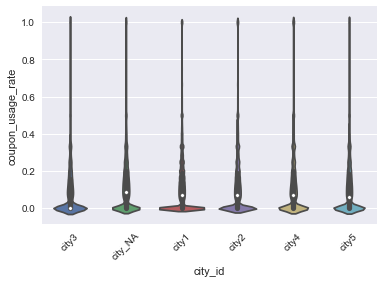

In [ ]:
data27 = pd.Series(dataset_180305[dataset_180305['city_id'].isnull()==False]['city_id'], name='city_id')
data28 = pd.Series(dataset_180305[dataset_180305['city_id'].isnull()==False]["coupon_usage_rate"], name="coupon_usage_rate")
g = sns.violinplot(data27, data28)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

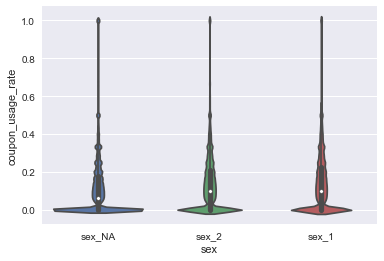

In [17]:
data29 = pd.Series(dataset_180305[dataset_180305['sex'].isnull()==False]['sex'], name='sex')
data30 = pd.Series(dataset_180305[dataset_180305['sex'].isnull()==False]["coupon_usage_rate"], name="coupon_usage_rate")
sns.violinplot(data29, data30)

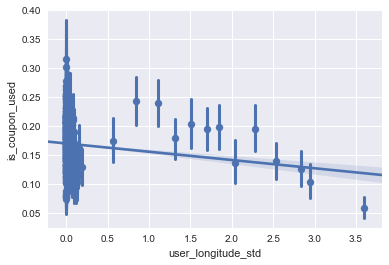

In [3]:
data31 = pd.Series(trainset[trainset["user_latitude_std"] > 0]["user_longitude_std"], name="user_longitude_std")
data32 = pd.Series(trainset[trainset["user_longitude_std"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data31, data32, x_estimator=np.mean, x_bins=1000)

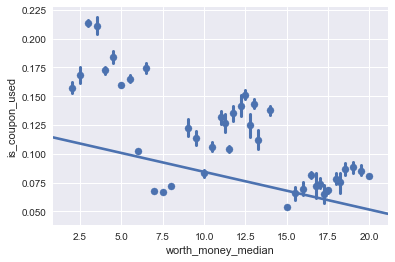

In [3]:
data33 = pd.Series(trainset[trainset["worth_money_median"] > 0]["worth_money_median"], name="worth_money_median")
data34 = pd.Series(trainset[trainset["worth_money_median"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data33, data34, x_estimator=np.mean, x_bins=500)

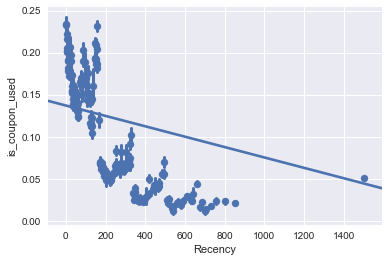

In [4]:
data35 = pd.Series(trainset[trainset["Recency"] > 0]["Recency"], name="Recency")
data36 = pd.Series(trainset[trainset["Recency"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data35, data36, x_estimator=np.mean, x_bins=500)

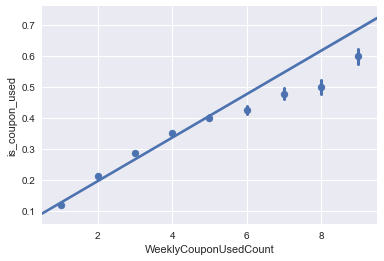

In [6]:
data37 = pd.Series(trainset[trainset["WeeklyCouponUsedCount"] > 0]["WeeklyCouponUsedCount"], name="WeeklyCouponUsedCount")
data38 = pd.Series(trainset[trainset["WeeklyCouponUsedCount"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data37, data38, x_estimator=np.mean, x_bins=1000)

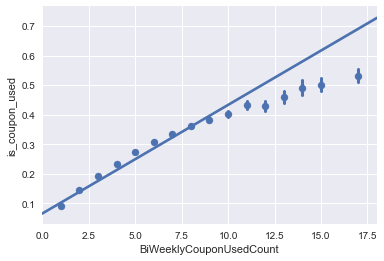

In [7]:
data39 = pd.Series(trainset[trainset["BiWeeklyCouponUsedCount"] > 0]["BiWeeklyCouponUsedCount"], name="BiWeeklyCouponUsedCount")
data40 = pd.Series(trainset[trainset["BiWeeklyCouponUsedCount"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data39, data40, x_estimator=np.mean, x_bins=1000)

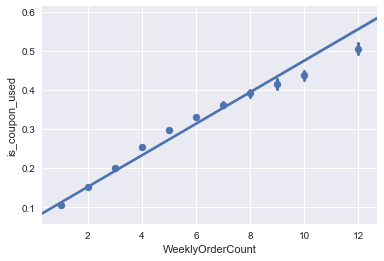

In [8]:
data41 = pd.Series(trainset[trainset["WeeklyOrderCount"] > 0]["WeeklyOrderCount"], name="WeeklyOrderCount")
data42 = pd.Series(trainset[trainset["WeeklyOrderCount"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data41, data42, x_estimator=np.mean, x_bins=500)

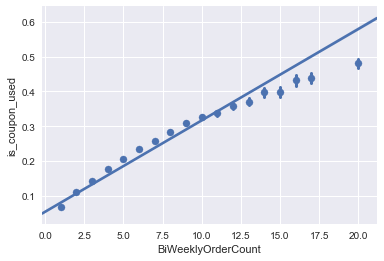

In [9]:
data43 = pd.Series(trainset[trainset["BiWeeklyOrderCount"] > 0]["BiWeeklyOrderCount"], name="BiWeeklyOrderCount")
data44 = pd.Series(trainset[trainset["BiWeeklyOrderCount"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data43, data44, x_estimator=np.mean, x_bins=500)

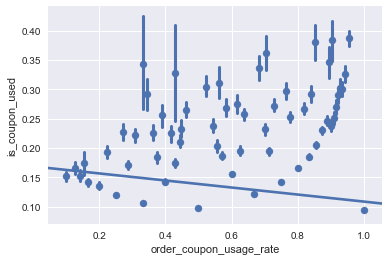

In [11]:
data45 = pd.Series(trainset[trainset["order_coupon_usage_rate"] > 0]["order_coupon_usage_rate"], name="order_coupon_usage_rate")
data46 = pd.Series(trainset[trainset["order_coupon_usage_rate"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data45, data46, x_estimator=np.mean, x_bins=500)

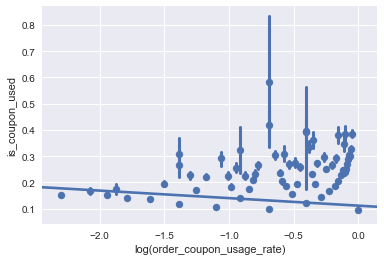

In [4]:
data45 = pd.Series(np.log(trainset[trainset["order_coupon_usage_rate"] > 0]["order_coupon_usage_rate"]), name="log(order_coupon_usage_rate)")
data46 = pd.Series(trainset[trainset["order_coupon_usage_rate"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data45, data46, x_estimator=np.mean, x_bins=500)

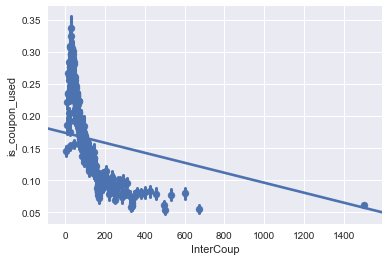

In [12]:
data47 = pd.Series(trainset[trainset["InterCoup"] > 0]["InterCoup"], name="InterCoup")
data48 = pd.Series(trainset[trainset["InterCoup"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data47, data48, x_estimator=np.mean, x_bins=500)

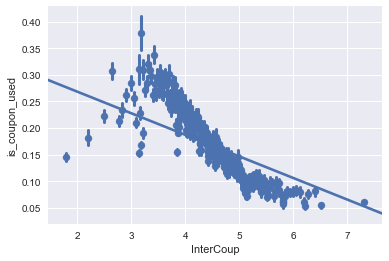

In [3]:
data49 = pd.Series(np.log(trainset[trainset["InterCoup"] > 0]["InterCoup"]), name="InterCoup")
data50 = pd.Series(trainset[trainset["InterCoup"] > 0]["is_used"], name="is_coupon_used")
sns.regplot(data49, data50, x_estimator=np.mean, x_bins=500)

In [51]:
trainset.head()

,user_coupon,user_id,coupon_id,start_time,is_used,sex_1,sex_2,age_60,age_70,age_80,age_90,age_0,city1,city2,city3,city4,city5,AppVerLast_2.1,AppVerLast_2.2,AppVerLast_2.3,AppVerLast_2.4,AppVerLast_2.5,AppVerLast_2.7,AppVerLast_2.8,kitchen_entropy,distance_median,distance_std,user_longitude_median,user_longitude_std,user_latitude_median,user_latitude_std,coupon_effective_days,money,max_money,covers_mon,covers_tue,covers_wed,covers_thu,covers_fri,covers_sat,covers_sun,type1,type6,Complaints,Eventsoperation,NewUserCouponPackageByBD,PreUserCouponCode,RecallUserDaily,home201603222253,home_dongbeiguan,home_jiangzhecai,home_muqinjie,home_xiangcaiguan,preuser,shareuser,商家拒单返券,家厨发券,活动赠券,码兑券,自运营赠券,蒲公英受邀,coupon_usage_rate,order_coupon_usage_rate,coupon_type1_usage_rate,coupon_type6_usage_rate,coupon_used_weekend_perc,order_weekend_perc,worth_money_median,worth_money_std,InterCoup,InterOrder,Recency,CoupUseLast,WeeklyCouponUsedCount,BiWeeklyCouponUsedCount,WeeklyOrderCount,BiWeeklyOrderCount
0,14_13159484,14,13159484,2016-04-08,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.242453,2156.0,833.795758,120.182450,1.573879,30.263791,3.930686,0.958333,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2,0.166667,0.333333,0.0,0.0,0.166667,8.0,0.0,1500.0,25.4,6.0,0.0,1.0,1.0,6.0,6.0
1,59_13161460,59,13161460,2016-04-08,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,857.0,0.000000,116.277084,0.000000,39.957024,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.0,-0.0,120.0,1500.0,0.0,0.0,0.0,2.0,2.0
2,59_13162460,59,13162460,2016-04-08,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,857.0,0.000000,116.277084,0.000000,39.957024,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.0,-0.0,120.0,1500.0,0.0,0.0,0.0,2.0,2.0
3,60_13161461,60,13161461,2016-04-08,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.0,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.0,-0.0,-0.0,1500.0,0.0,0.0,0.0,0.0,0.0
4,60_13162461,60,13162461,2016-04-08,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1365.0,0.000000,116.430900,0.000000,39.917430,0.000000,0.958333,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,8.0,0.0,-0.0,-0.0,1500.0,0.0,0.0,0.0,0.0,0.0
